In [ ]:
!pip install yfinance
!pip install pyvinecopulib
!pip install copulae --ignore-requires-python

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [20, 9]
sns.set_palette('viridis')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Introduction

Let us first define a portfolio consisting of multiple indices. We have purposefully selected some of the biggest ones from three continents: North America, Europe and Asia.

In [ ]:
# access the Yahoo Finance API directly in Python
# https://github.com/ranaroussi/yfinance
import yfinance as yf

tickers = [
    '^GSPC',        # S&P 500                   USA
    '^DJI',         # Dow 30                    USA
    '^IXIC',        # Nasdaq                    USA
    '^RUT',         # Russell 2000              USA
    '^FTSE',        # FTSE 100                  United Kingdom
    '^GDAXI',       # DAX Performance Index     Germany
    '^FCHI',        # CAC 40                    France
    '^BFX',         # BEL 20                    Belgium
    '^N225',        # Nikkei 225                Japan
    '^HSI',         # Hang Seng Index           Hong Kong
    '000001.SS',    # SSE Composite Index       China
    '^BSESN',       # BSE Sensex                India
]

# build a dataframe with the indices' daily close values since 2010-01-01
dataset = pd.DataFrame(index=pd.date_range(start='2010', end='2020-04-30', freq='B'))
for ticker in tickers:
    asset = yf.Ticker(ticker).history(period='max')[['Close']]
    asset.columns = [ticker]
    dataset = dataset.join(asset)

Now to be able to compare all these assets, we make sure to have them fully synchronised and normalised. We drop rows (trading days) on which we do not have data for all indices--for example due to holidays not always happening simultaneously.

To normalise we convert the index's daily value to the percentage change relative to the previous day.

In [ ]:
# drop all those rows with missing data
dataset = dataset.dropna()

# convert to daily loss
dataset = dataset.pct_change().dropna() * -1

In [ ]:
dataset.to_csv('dataset.csv')
dataset

^GSPC      ^DJI     ^IXIC  ...      ^HSI  000001.SS    ^BSESN
2010-01-05 -0.003116  0.001128 -0.000126  ... -0.020909  -0.011844 -0.007262
2010-01-06 -0.000546 -0.000157  0.003301  ... -0.006153   0.008519 -0.000842
2010-01-07 -0.004001 -0.003138  0.000452  ...  0.006567   0.018880  0.004825
2010-01-08 -0.002882 -0.001068 -0.007443  ... -0.001226  -0.001009  0.004282
2010-01-12  0.007651 -0.000854  0.015044  ... -0.001341  -0.024396  0.006715
...              ...       ...       ...  ...       ...        ...       ...
2020-04-22 -0.022930 -0.019851 -0.028094  ... -0.004195  -0.006003 -0.024247
2020-04-23  0.000539 -0.001680  0.000074  ... -0.003514   0.001927 -0.015409
2020-04-24 -0.013918 -0.011057 -0.016454  ...  0.006089   0.010558  0.016818
2020-04-27 -0.014714 -0.015079 -0.011076  ... -0.018833  -0.002482 -0.013275
2020-04-28  0.005242  0.001335  0.014024  ... -0.012184   0.001946 -0.011701

[2103 rows x 12 columns]

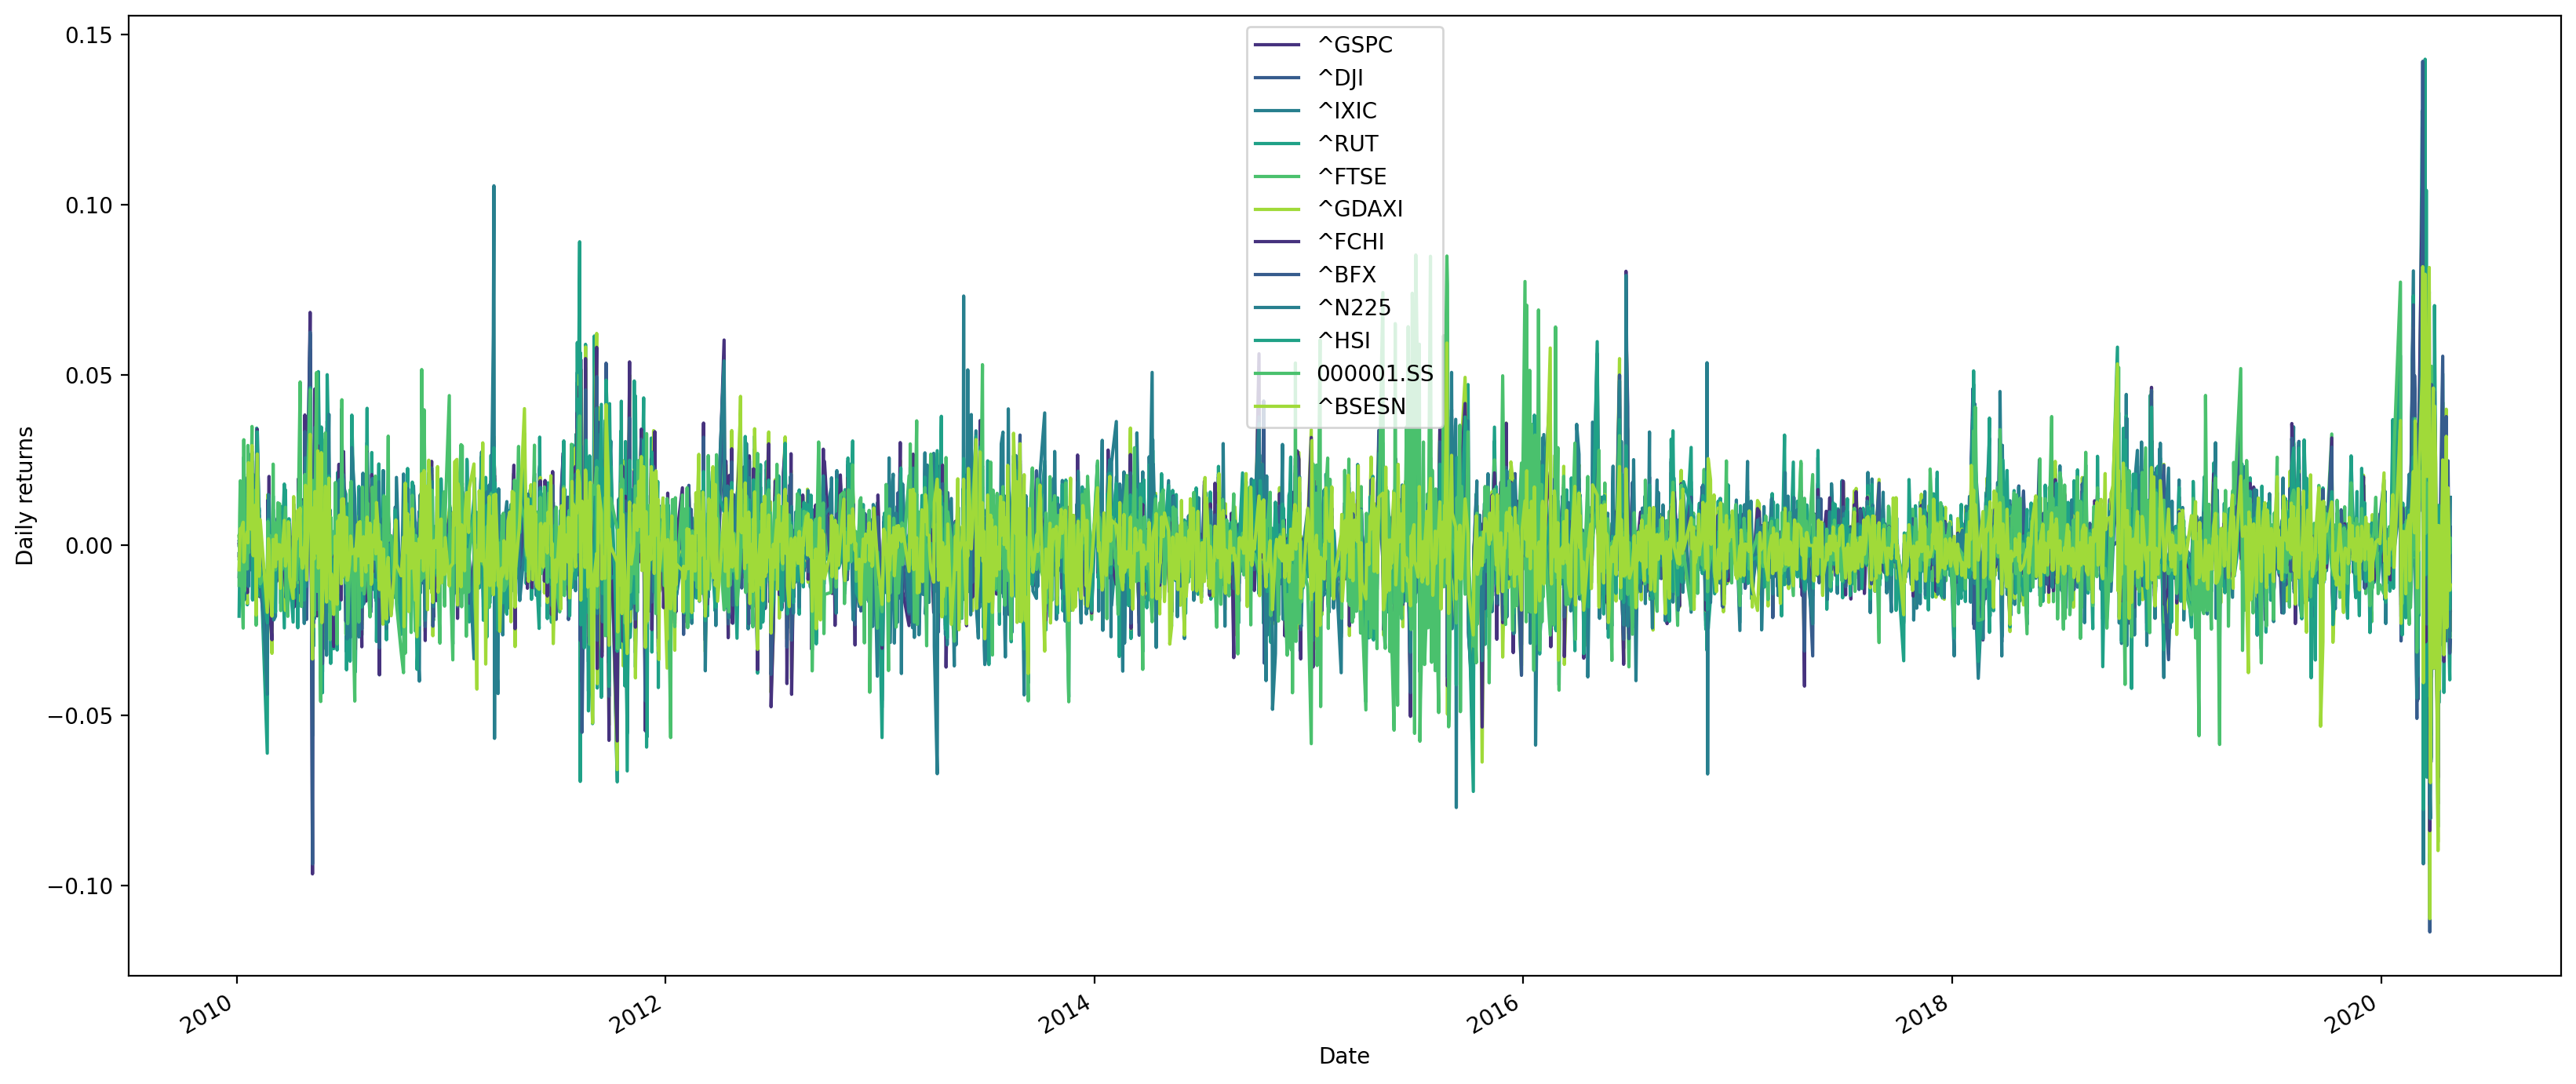

In [ ]:
dataset.plot()
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.show()

# Principal Component Analysis (PCA)

Although a technique already more than a hundred years old (Pearson 1901), *principal component analysis* (PCA) is still being used widely today. The main idea behind it is to find the main underlying dimensions of a correlated dataset. This reduction in dimensionality can create new insights or make the dataset more manageable.

Its first step is to find the direction of maximum variance; this will be the first component. This is the direction along which all of the dataset's features are most correlated with each other. The second component is then found by again identifying a direction which correlates the most, but this time being orthagonal to the first component. This can continue on for as long as there are features. Principal components derived like this are also called *eigenvectors*.

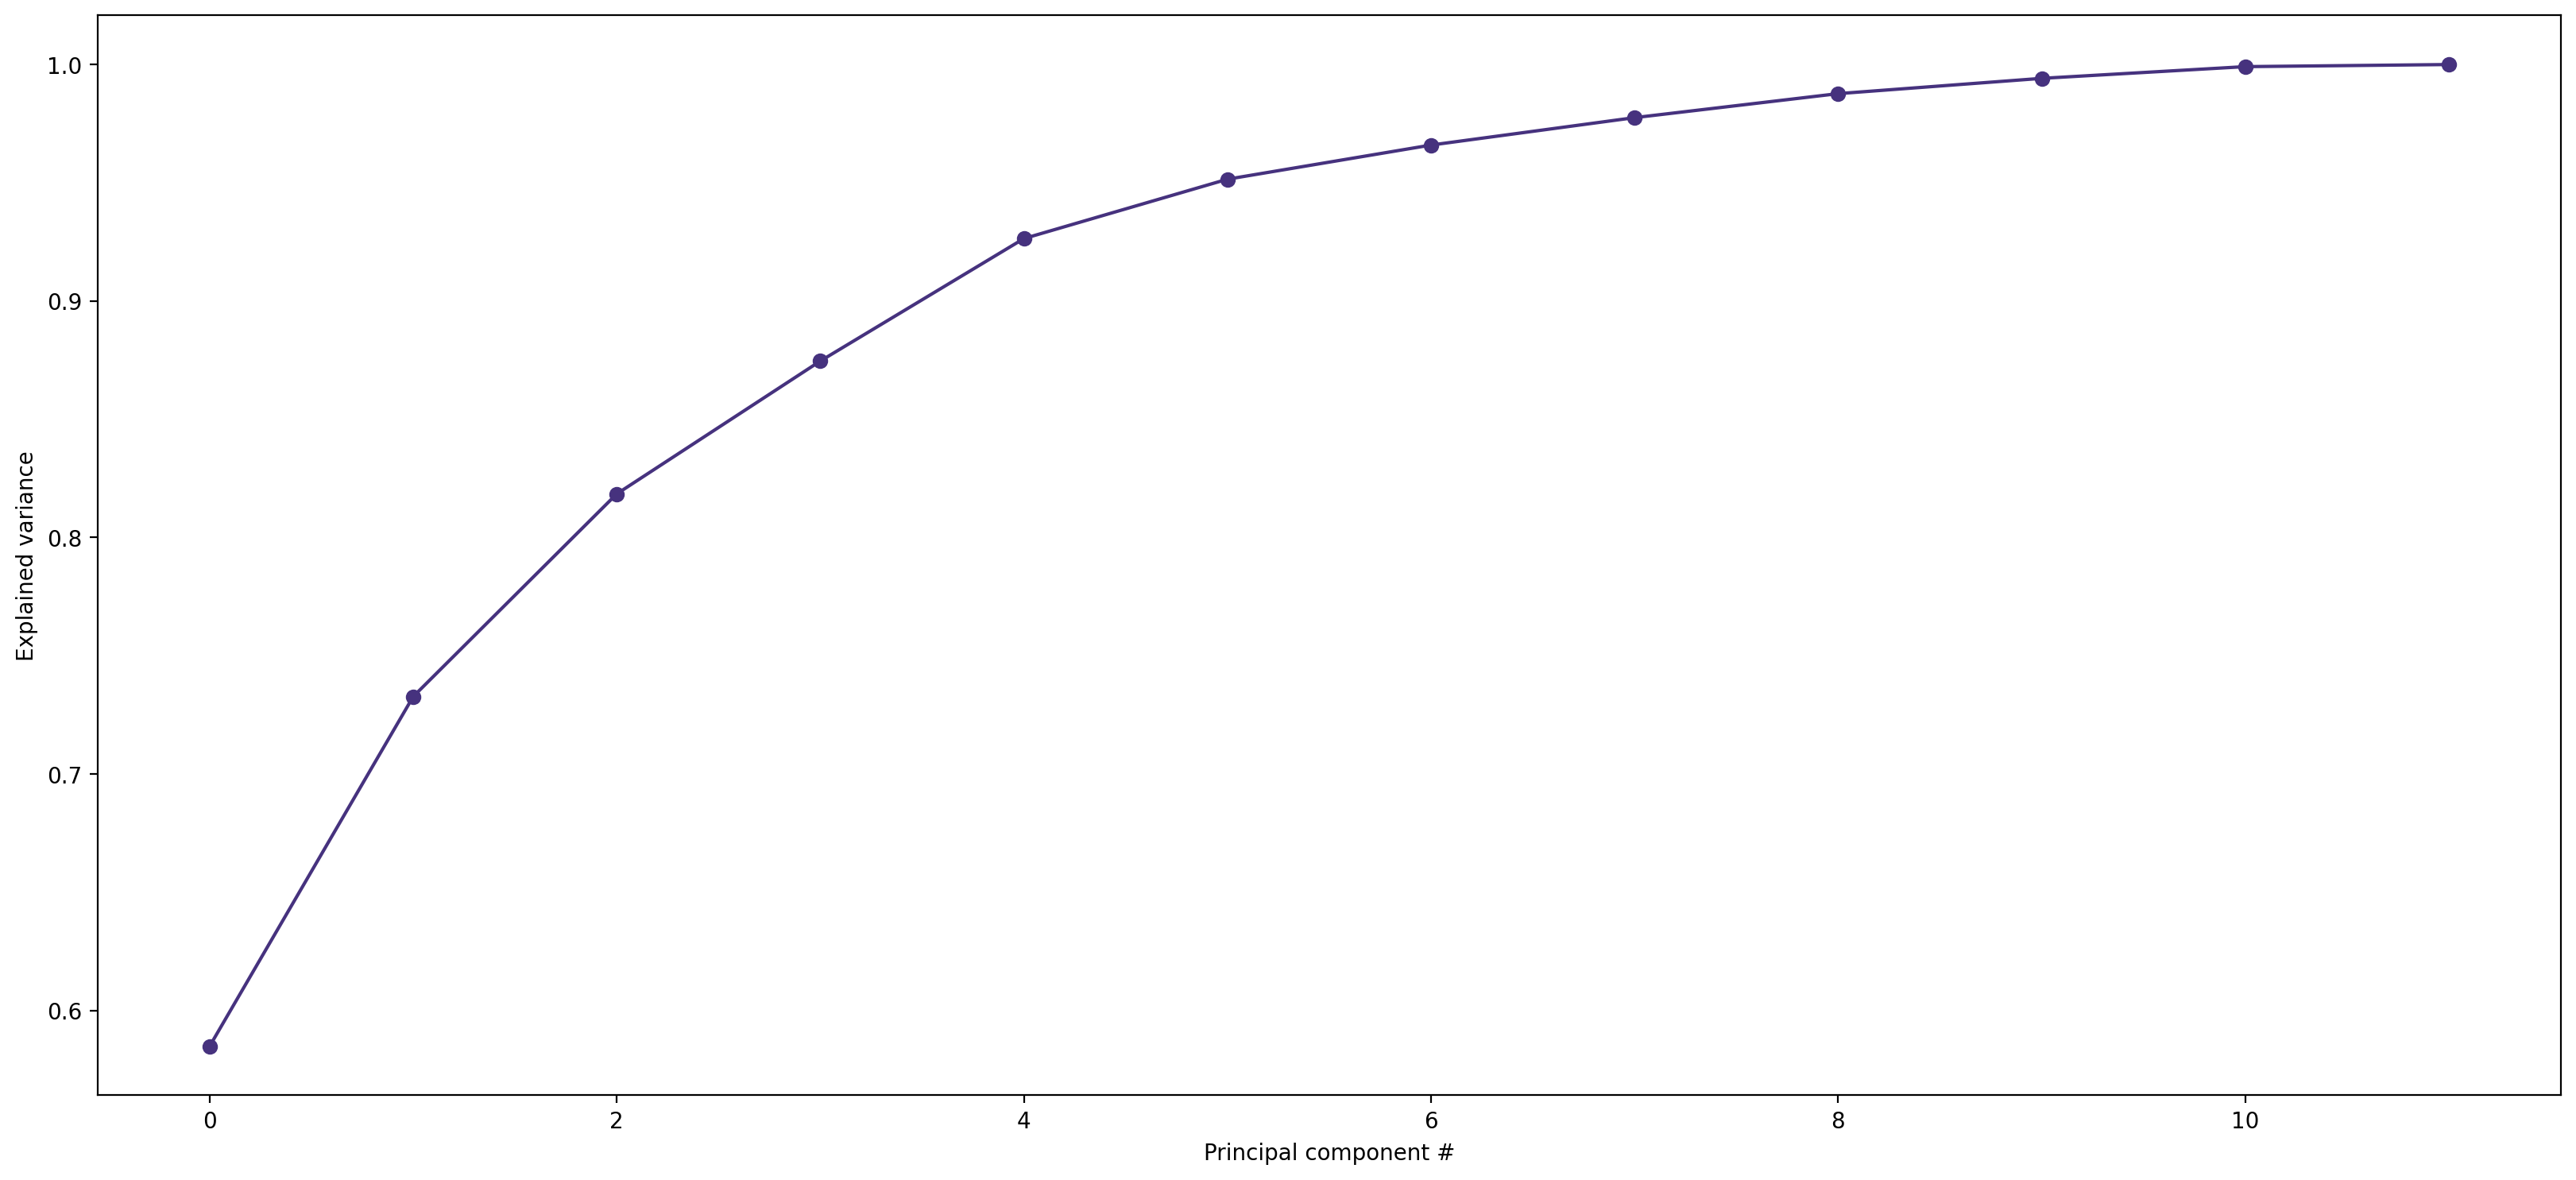

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(StandardScaler().fit_transform(dataset))
expl_var = pca.explained_variance_ratio_
pd.DataFrame(expl_var.cumsum()).plot(style='-o', legend=False)
plt.xlabel('Principal component #')
plt.ylabel('Explained variance')
plt.show()

As can be seen here, the first principal component identified by the `PCA` model is already able to explain a signifcant amount (`58,5%`) of the variance of the total dataset. By also considering the second and third components, we are already able to explain more than `80%`!

This means that we can have quite a good idea of what our portfolio is doing without having to keep track of all of the original (twelve) assets.

Let's plot the correlation of each index in respect to these components and take a look at some possible interpretations.

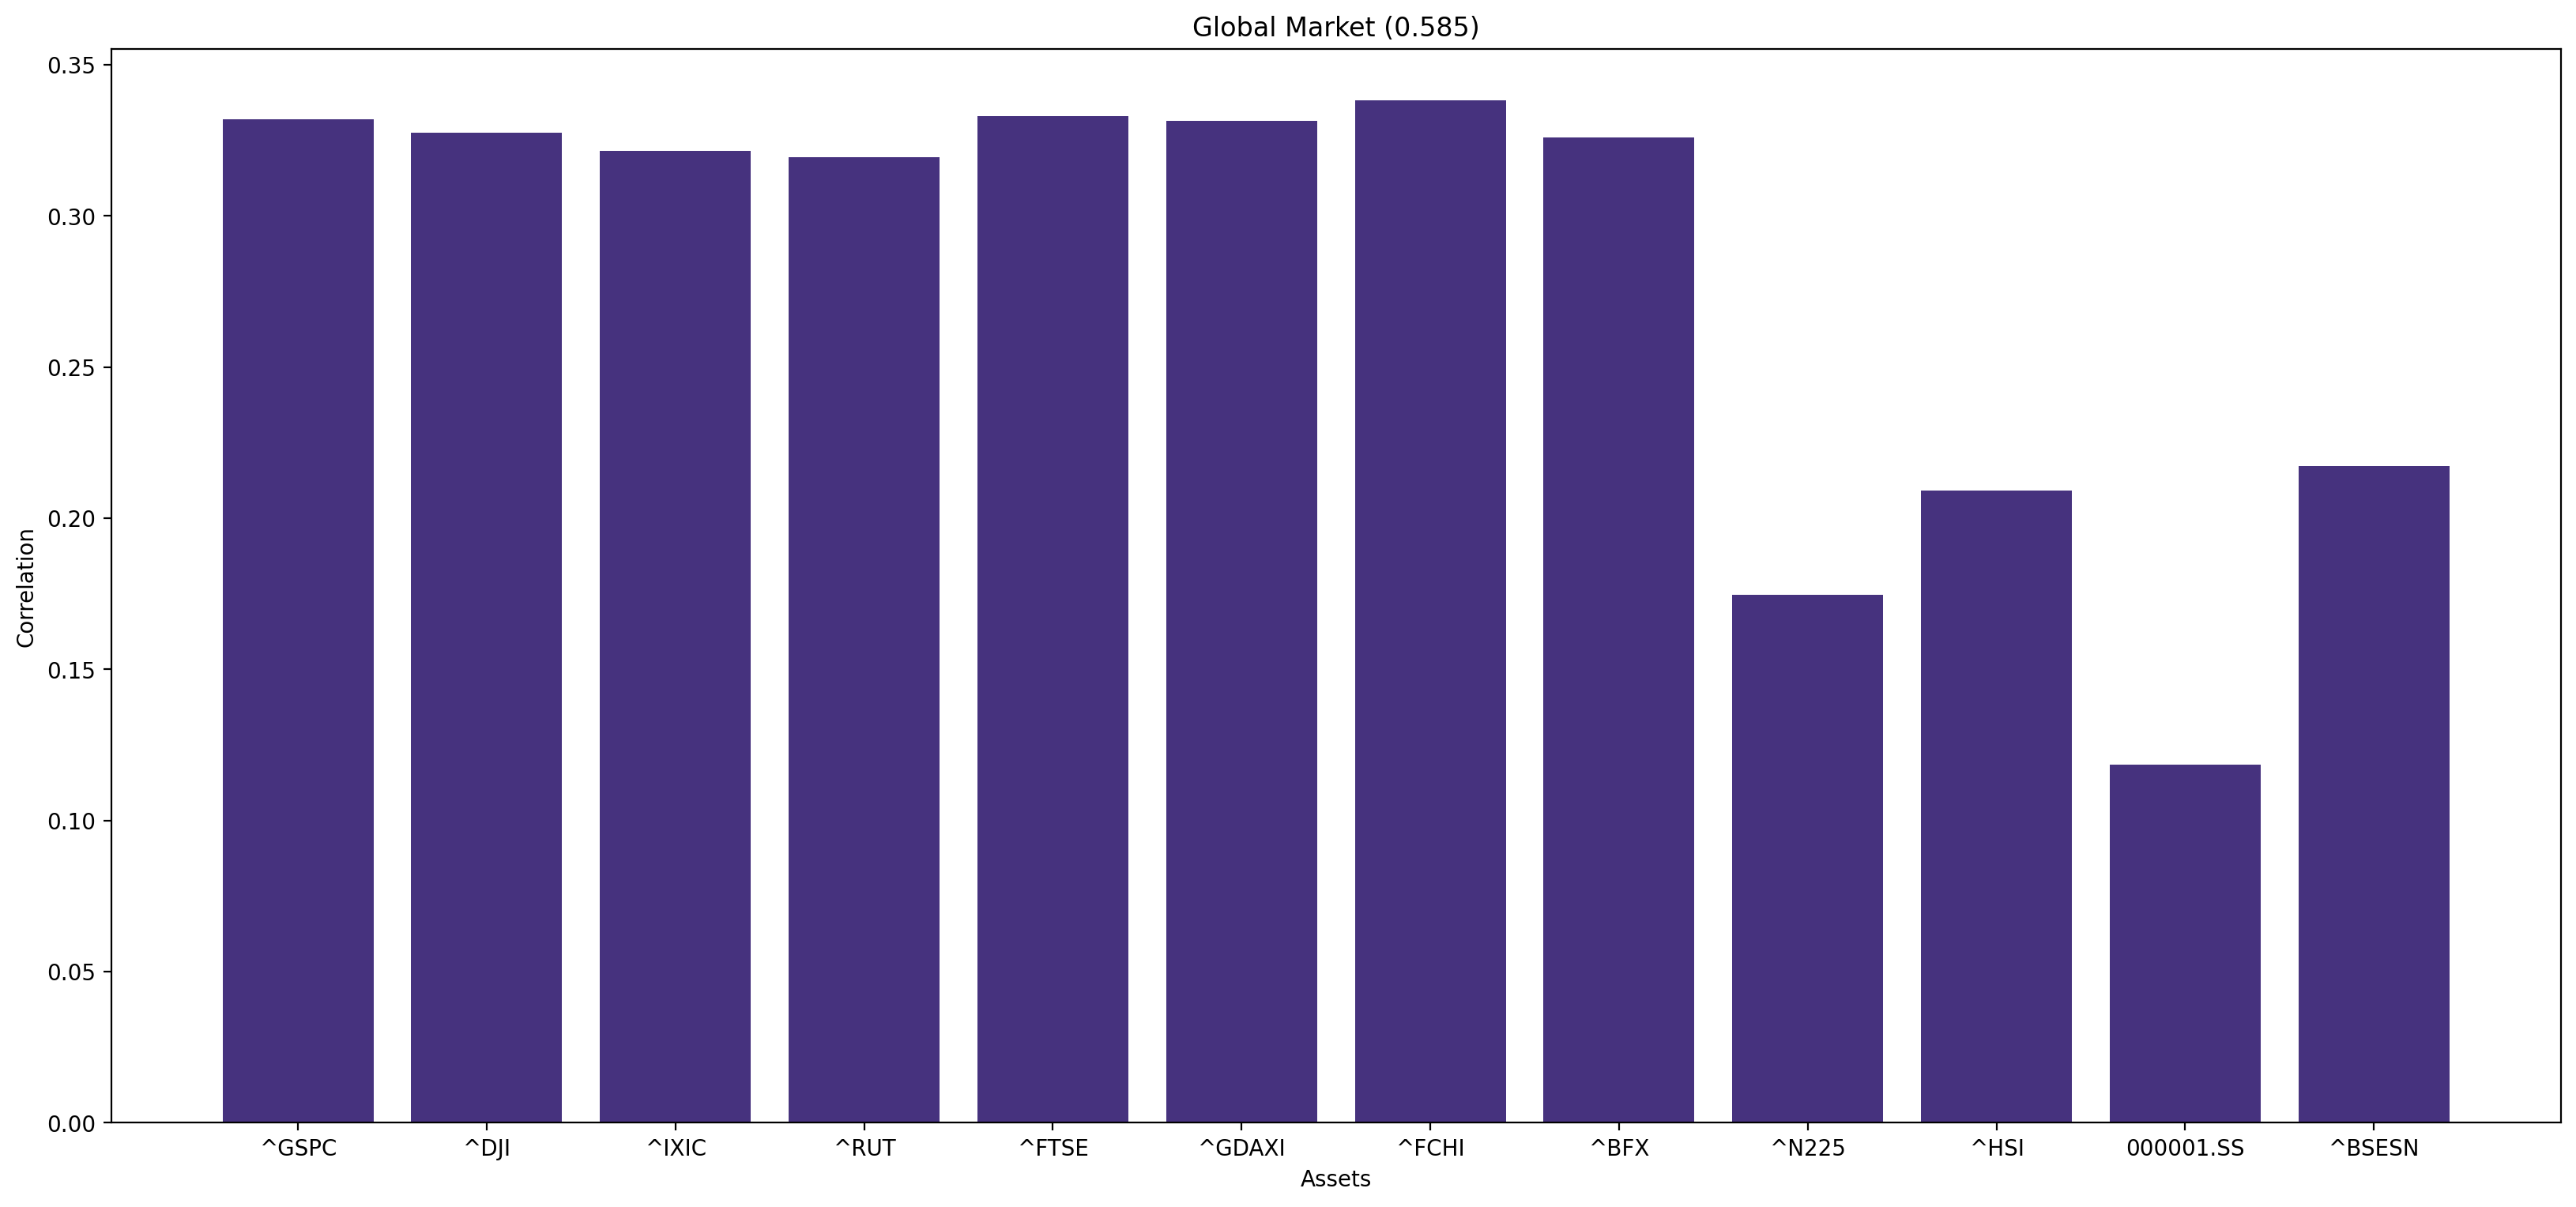

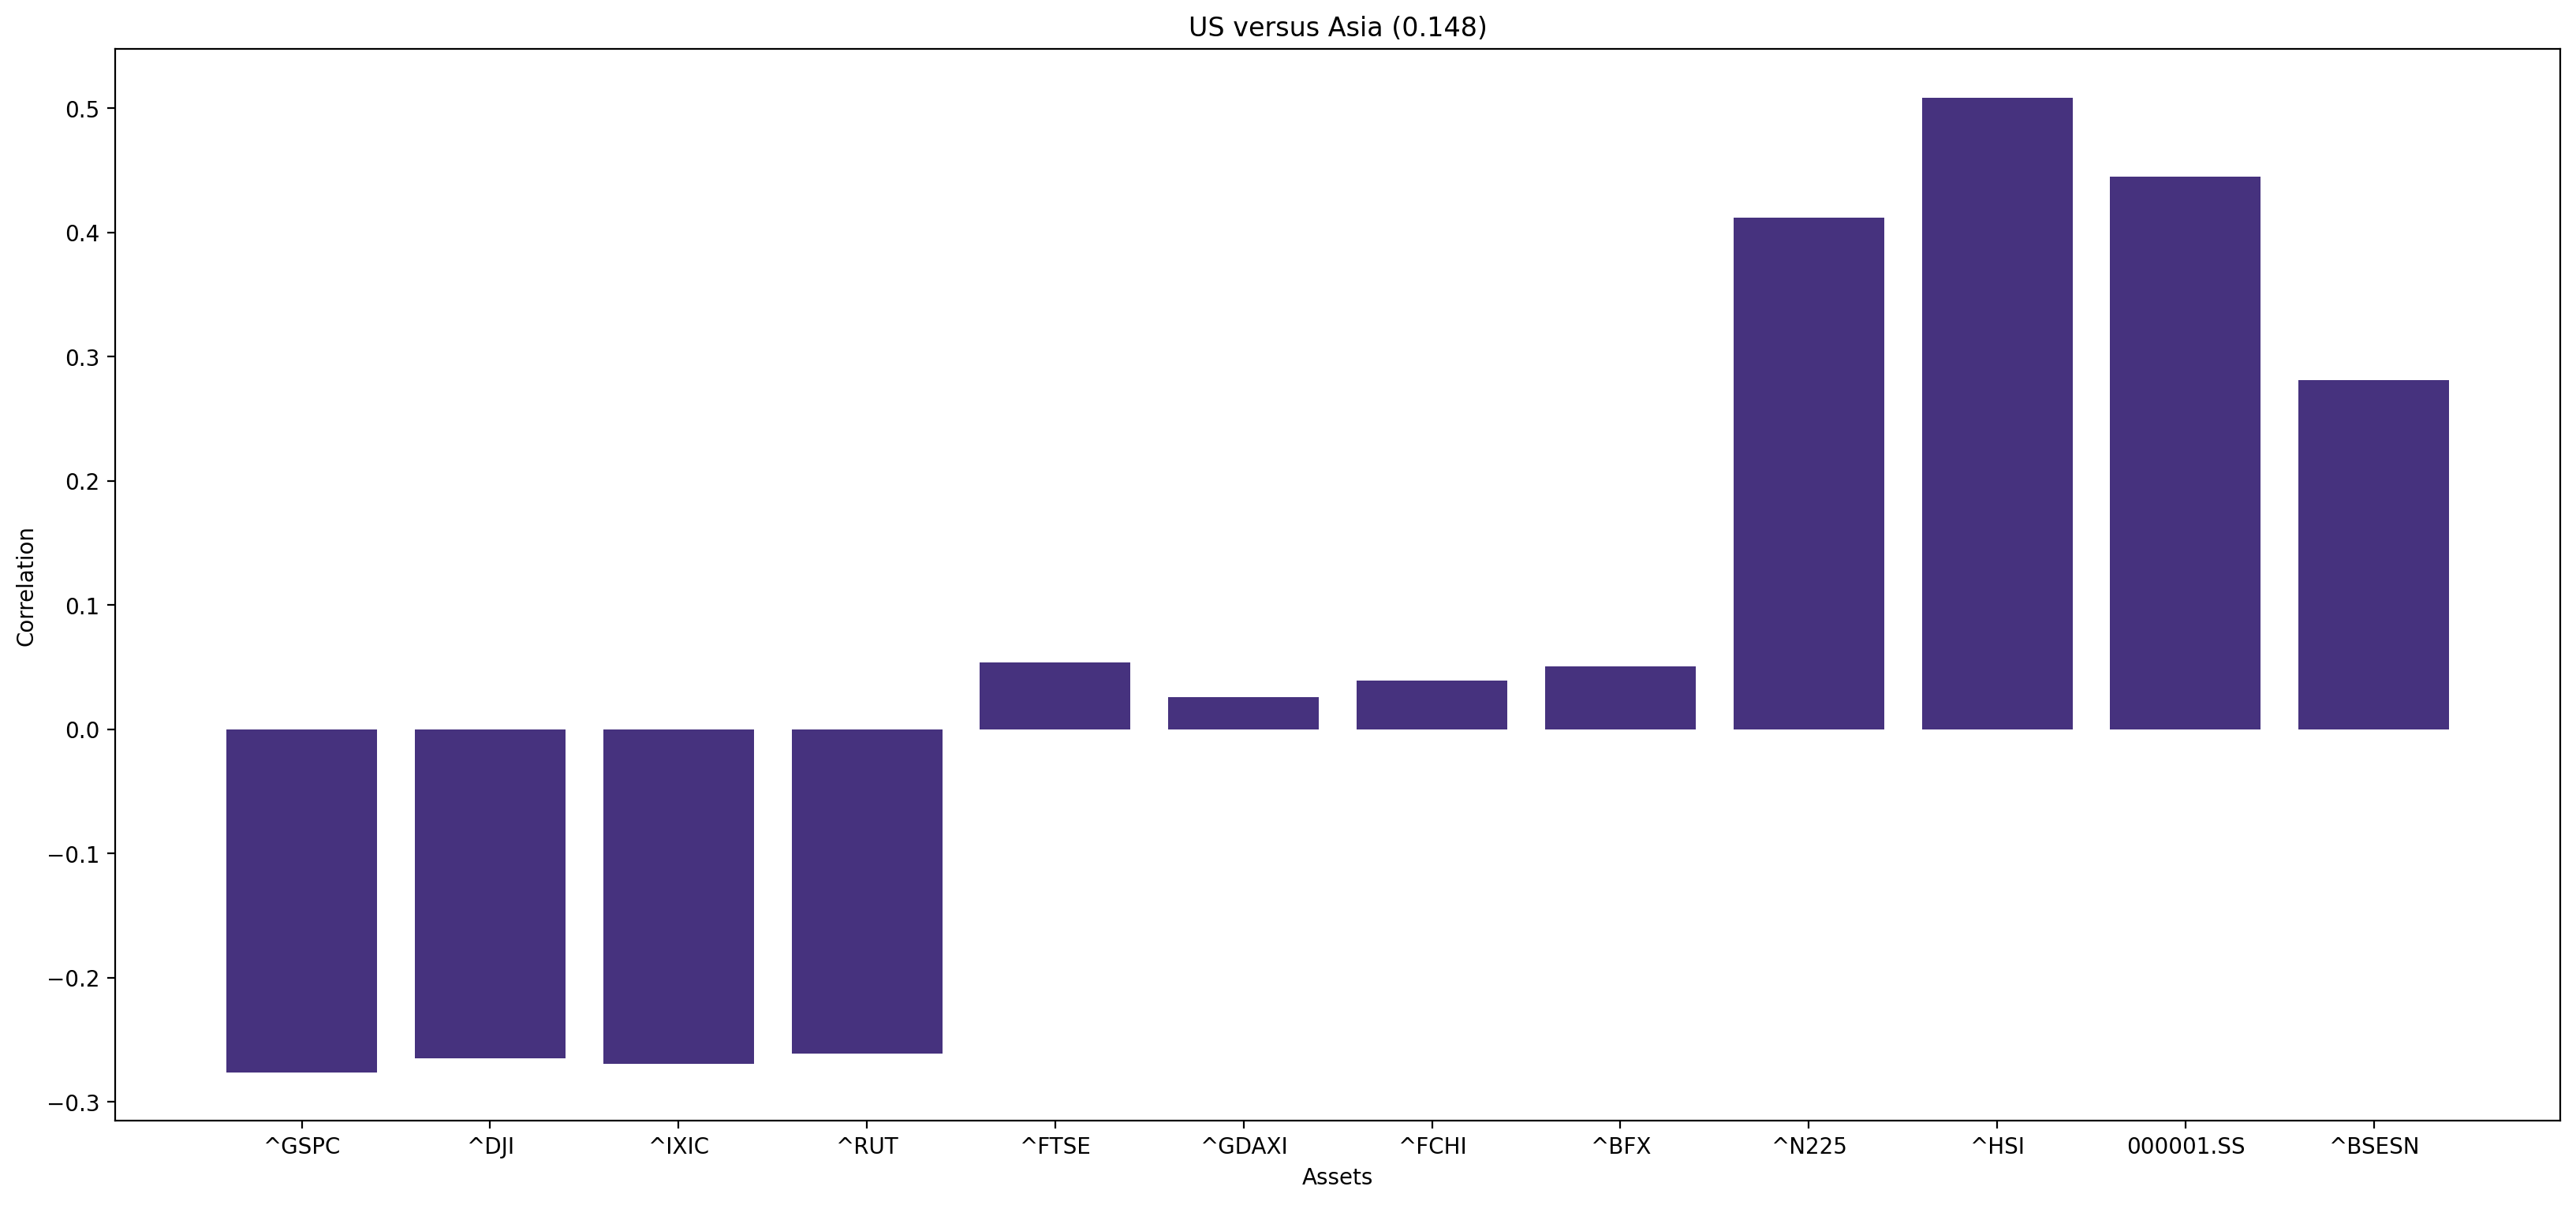

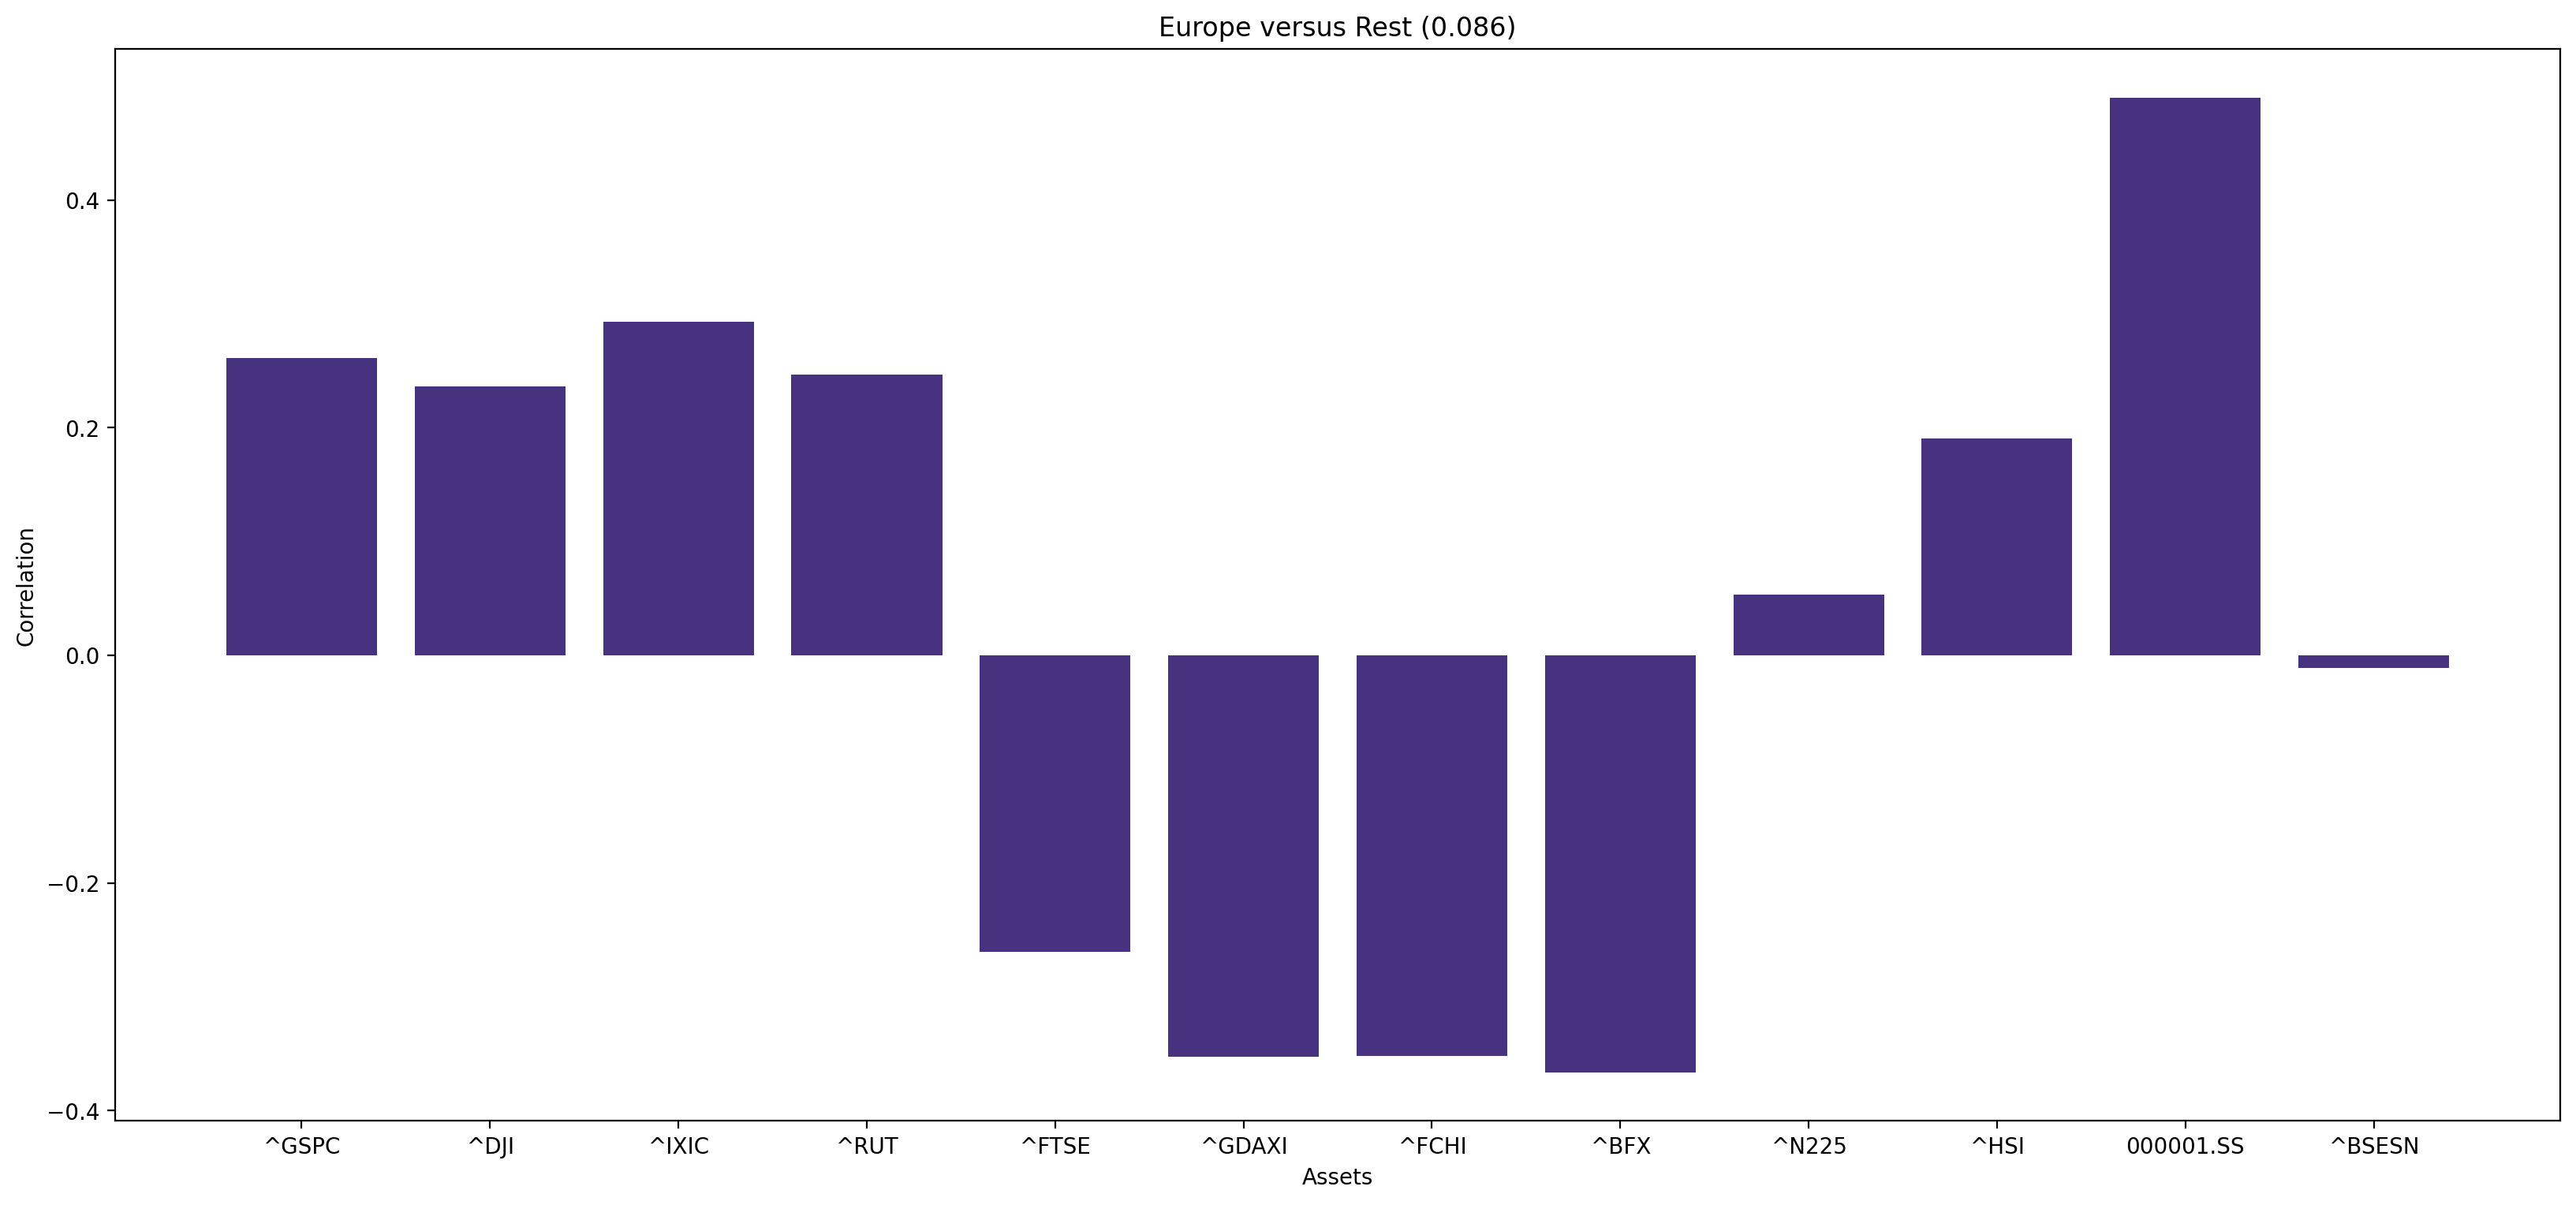

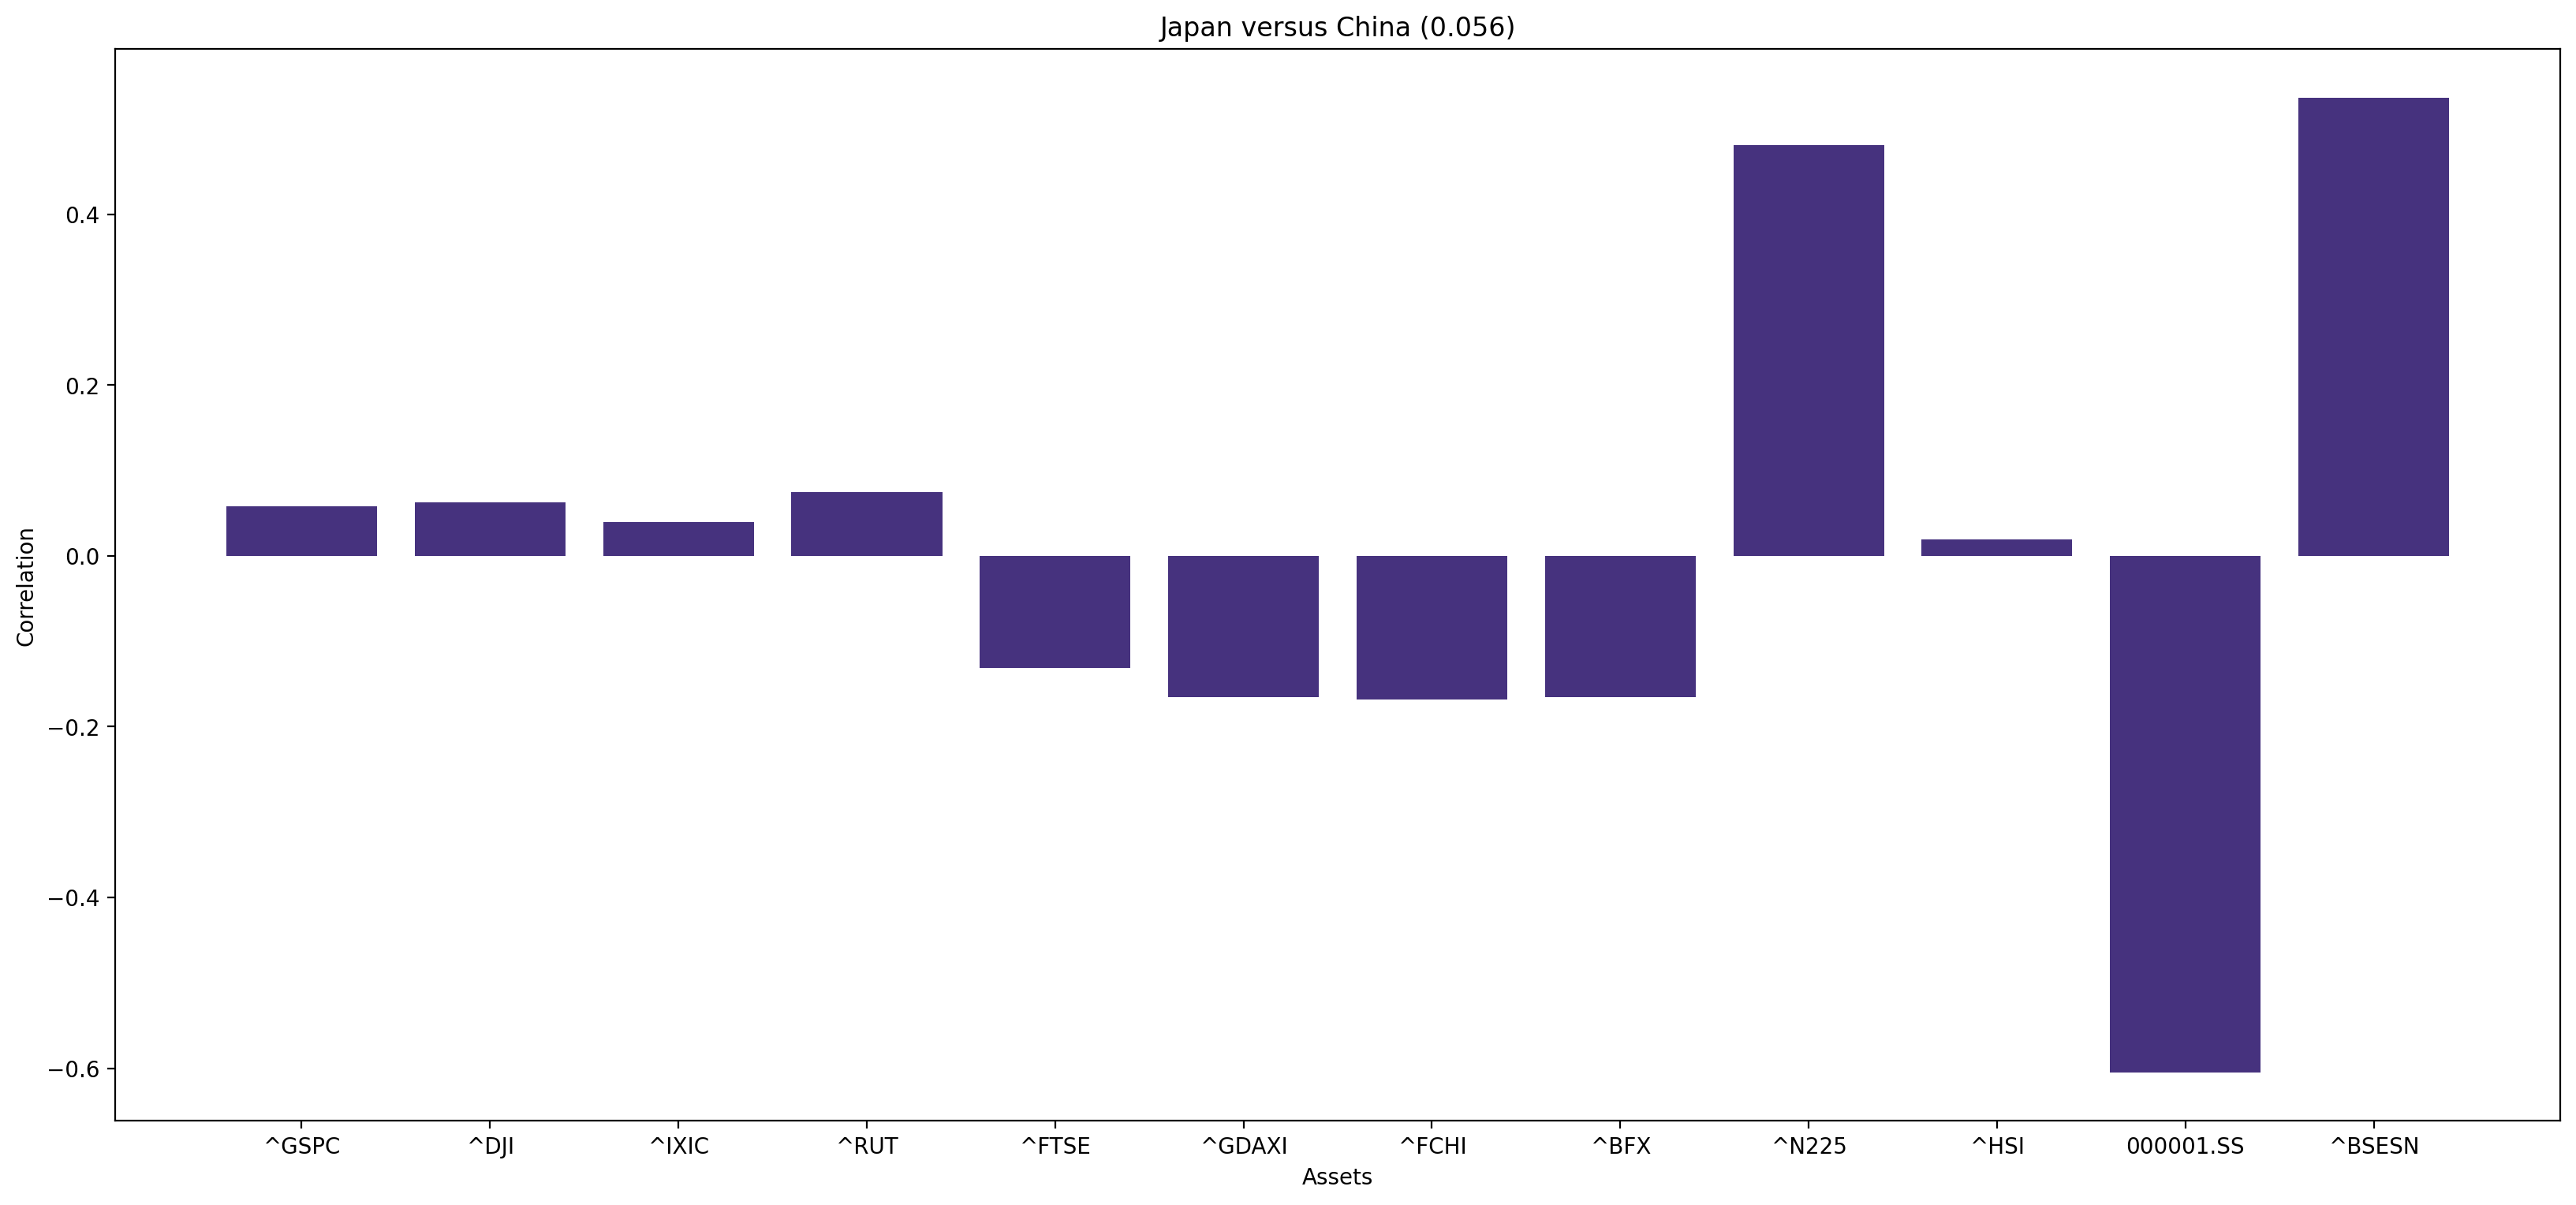

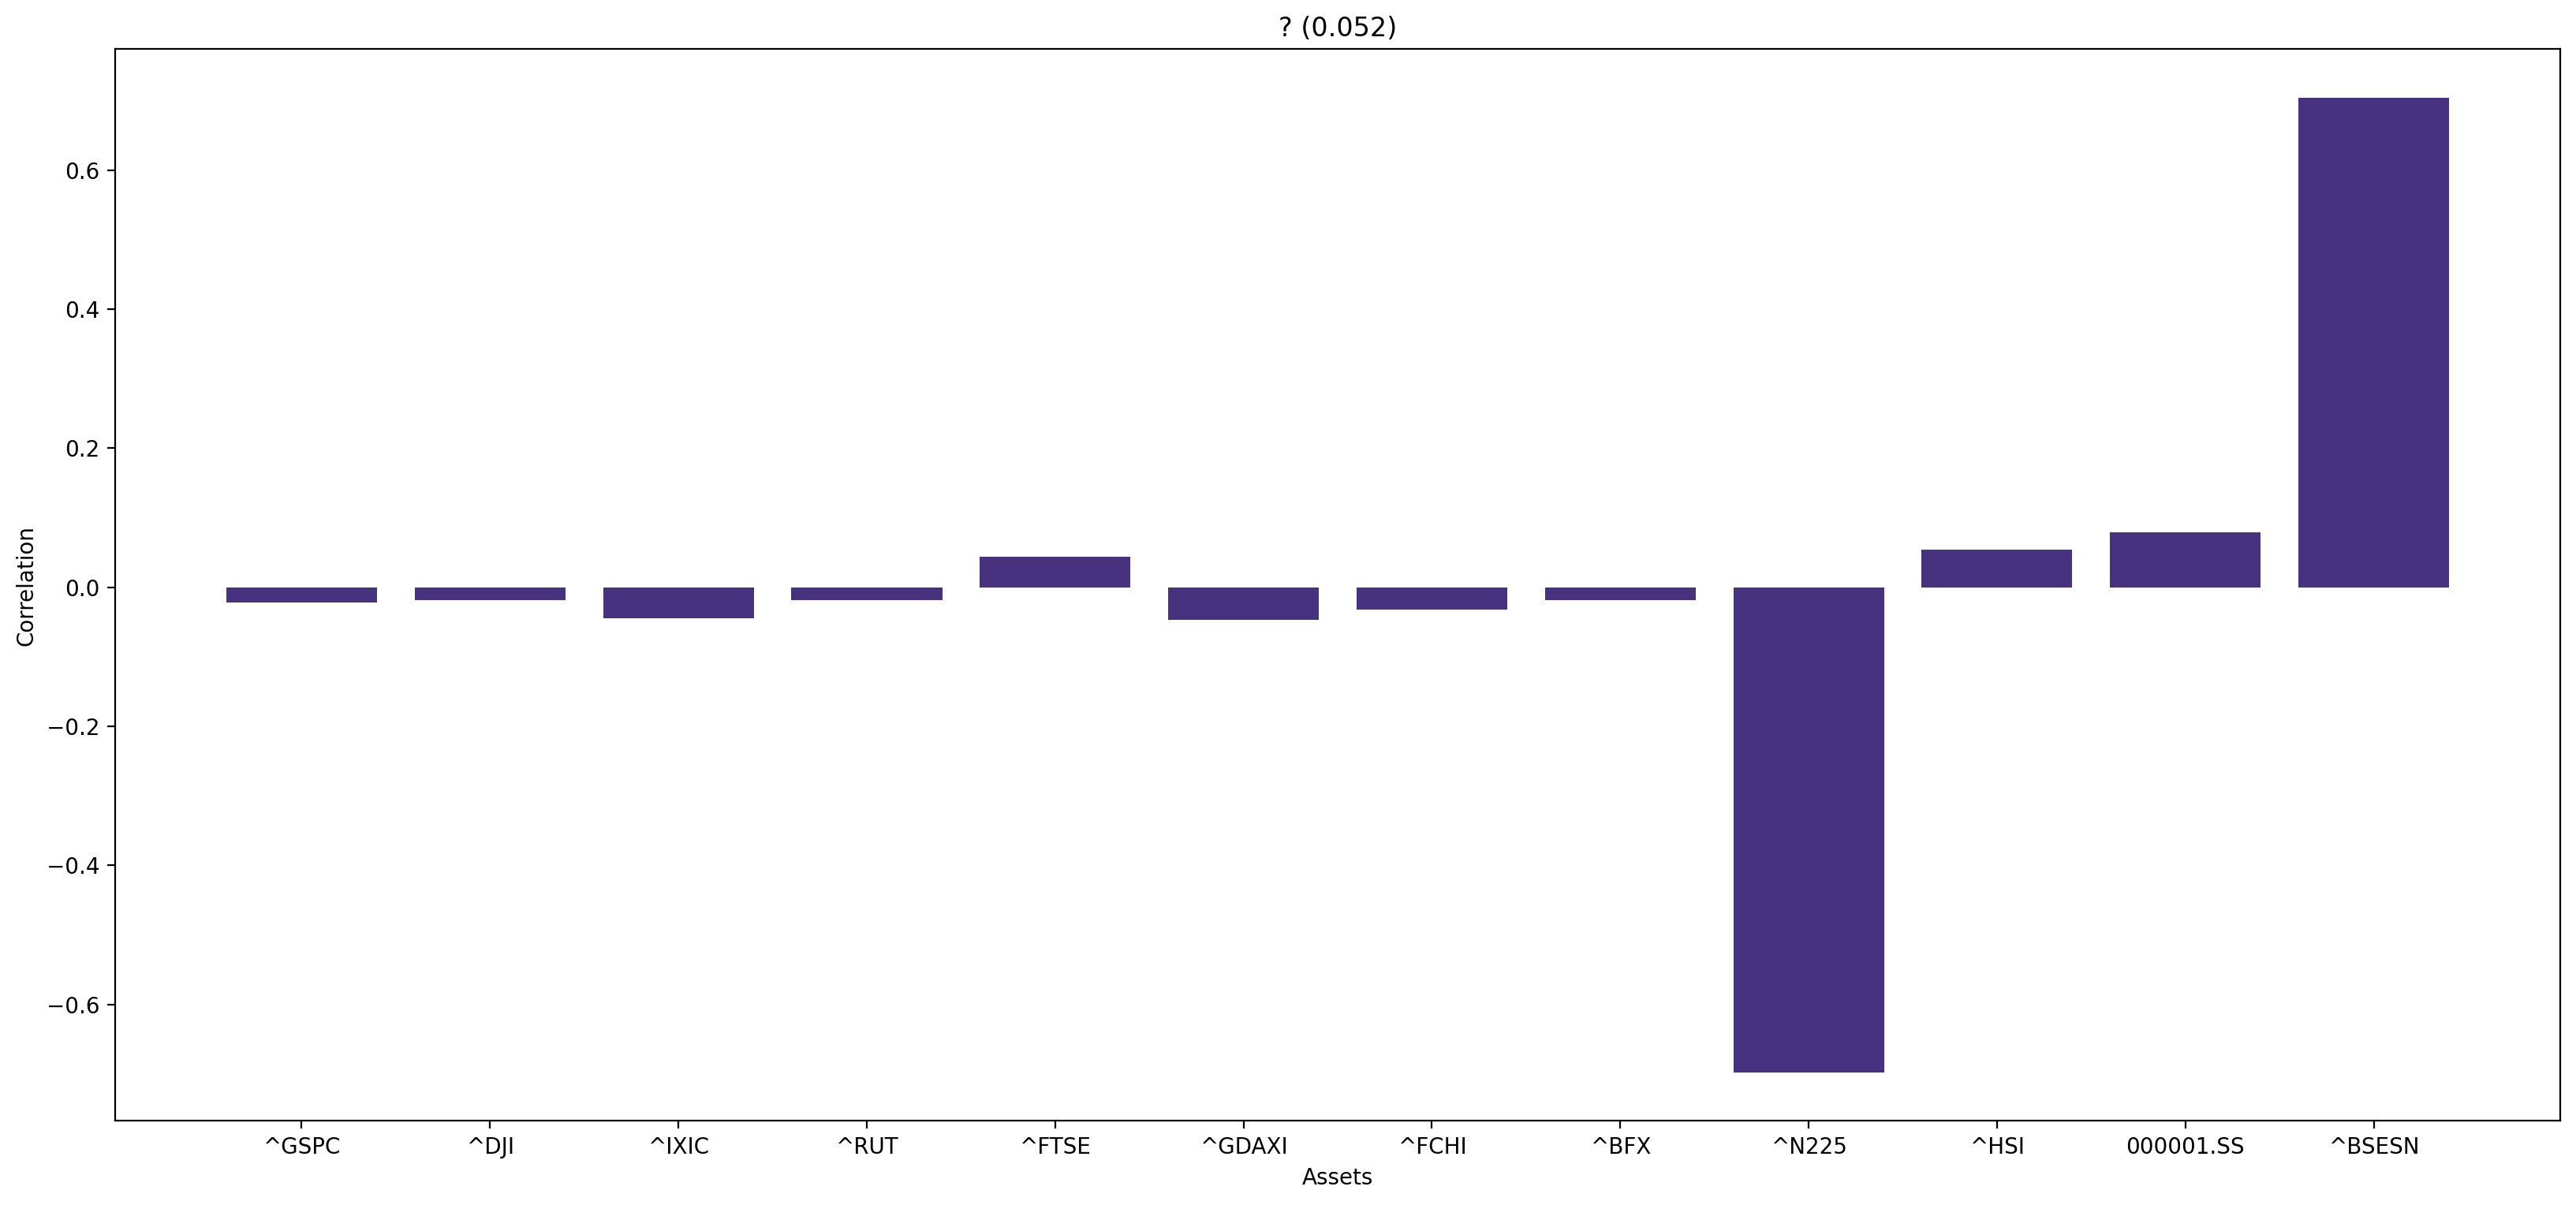

In [ ]:
component_labels = {
    0: f'Global Market ({round(expl_var[0], 3)})',
    1: f'US versus Asia ({round(expl_var[1], 3)})',
    2: f'Europe versus Rest ({round(expl_var[2], 3)})',
    3: f'Japan versus China ({round(expl_var[3], 3)})',
    4: f'? ({round(expl_var[4], 3)})'
}

for n, component in enumerate(pca.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xticks(dataset.columns)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

The first component is a general one; all indices correlate negatively with it. Basically this means that there is a direction in the data along which all the indices move together. We can label this direction as the global economy as a whole; all these markets share some form of dependency.

The second component shows positive correlation for *all* American indices and a negative correlation for *all* Asian indices. This opposition means that American markets go up when Asian markets go down and vice versa. It is interesting to note that European markets barely correlate with this dimension; i.e. they are independent of these market movements.

The third biggest component does involve European markets, and basically shows a negative correlation with the all of the other indices. Contrary to what we saw in the second component, in this component American and Asian markets do move together.

Not all components can be interpreted this clearly though. The fourth still allows for some interpretation but this becomes more difficult for the fifth. Bear in mind that these components also start to matter less and less; the fifth component only explains `5,2%` of the dataset's total variance whereas the first does so for `58,5%`.

Finally we want to determine how many components we actually need. One could apply an arbitrary threshold such as `80%` or look at the cumulative explained variance plot and determine where the 'elbow' is. However, instead we choose a method which requires the eigenvector's *eigenvalue* to be `> 1`. It should be noted no single method has been proven to be the best and they can all give different results. For a thorough review of various methods see Cangelosi (2007).

In [ ]:
pd.DataFrame({
    'Eigenvalues': pca.explained_variance_, 
    'Retain?': pca.explained_variance_ > 1,
    'Explained Variance': expl_var,
    'Cumulative Expl. Var.': expl_var.cumsum()
})

Eigenvalues  Retain?  Explained Variance  Cumulative Expl. Var.
0      7.021576     True            0.584853               0.584853
1      1.775329     True            0.147874               0.732727
2      1.029014     True            0.085710               0.818437
3      0.674560    False            0.056187               0.874624
4      0.621712    False            0.051785               0.926409
5      0.301404    False            0.025105               0.951514
6      0.173352    False            0.014439               0.965953
7      0.139188    False            0.011593               0.977546
8      0.121848    False            0.010149               0.987695
9      0.077626    False            0.006466               0.994161
10     0.059476    False            0.004954               0.999115
11     0.010623    False            0.000885               1.000000

# Factor Analysis

*Factor analysis* (FA) differs from PCA for one in the fact that it loosens the requirement of components having an orthagonal rotation between them. This freedom can allow for a single component to explain even more variance then the eigenvectors derived from PCA. Another big difference is the fact that FA only considers the common variance.

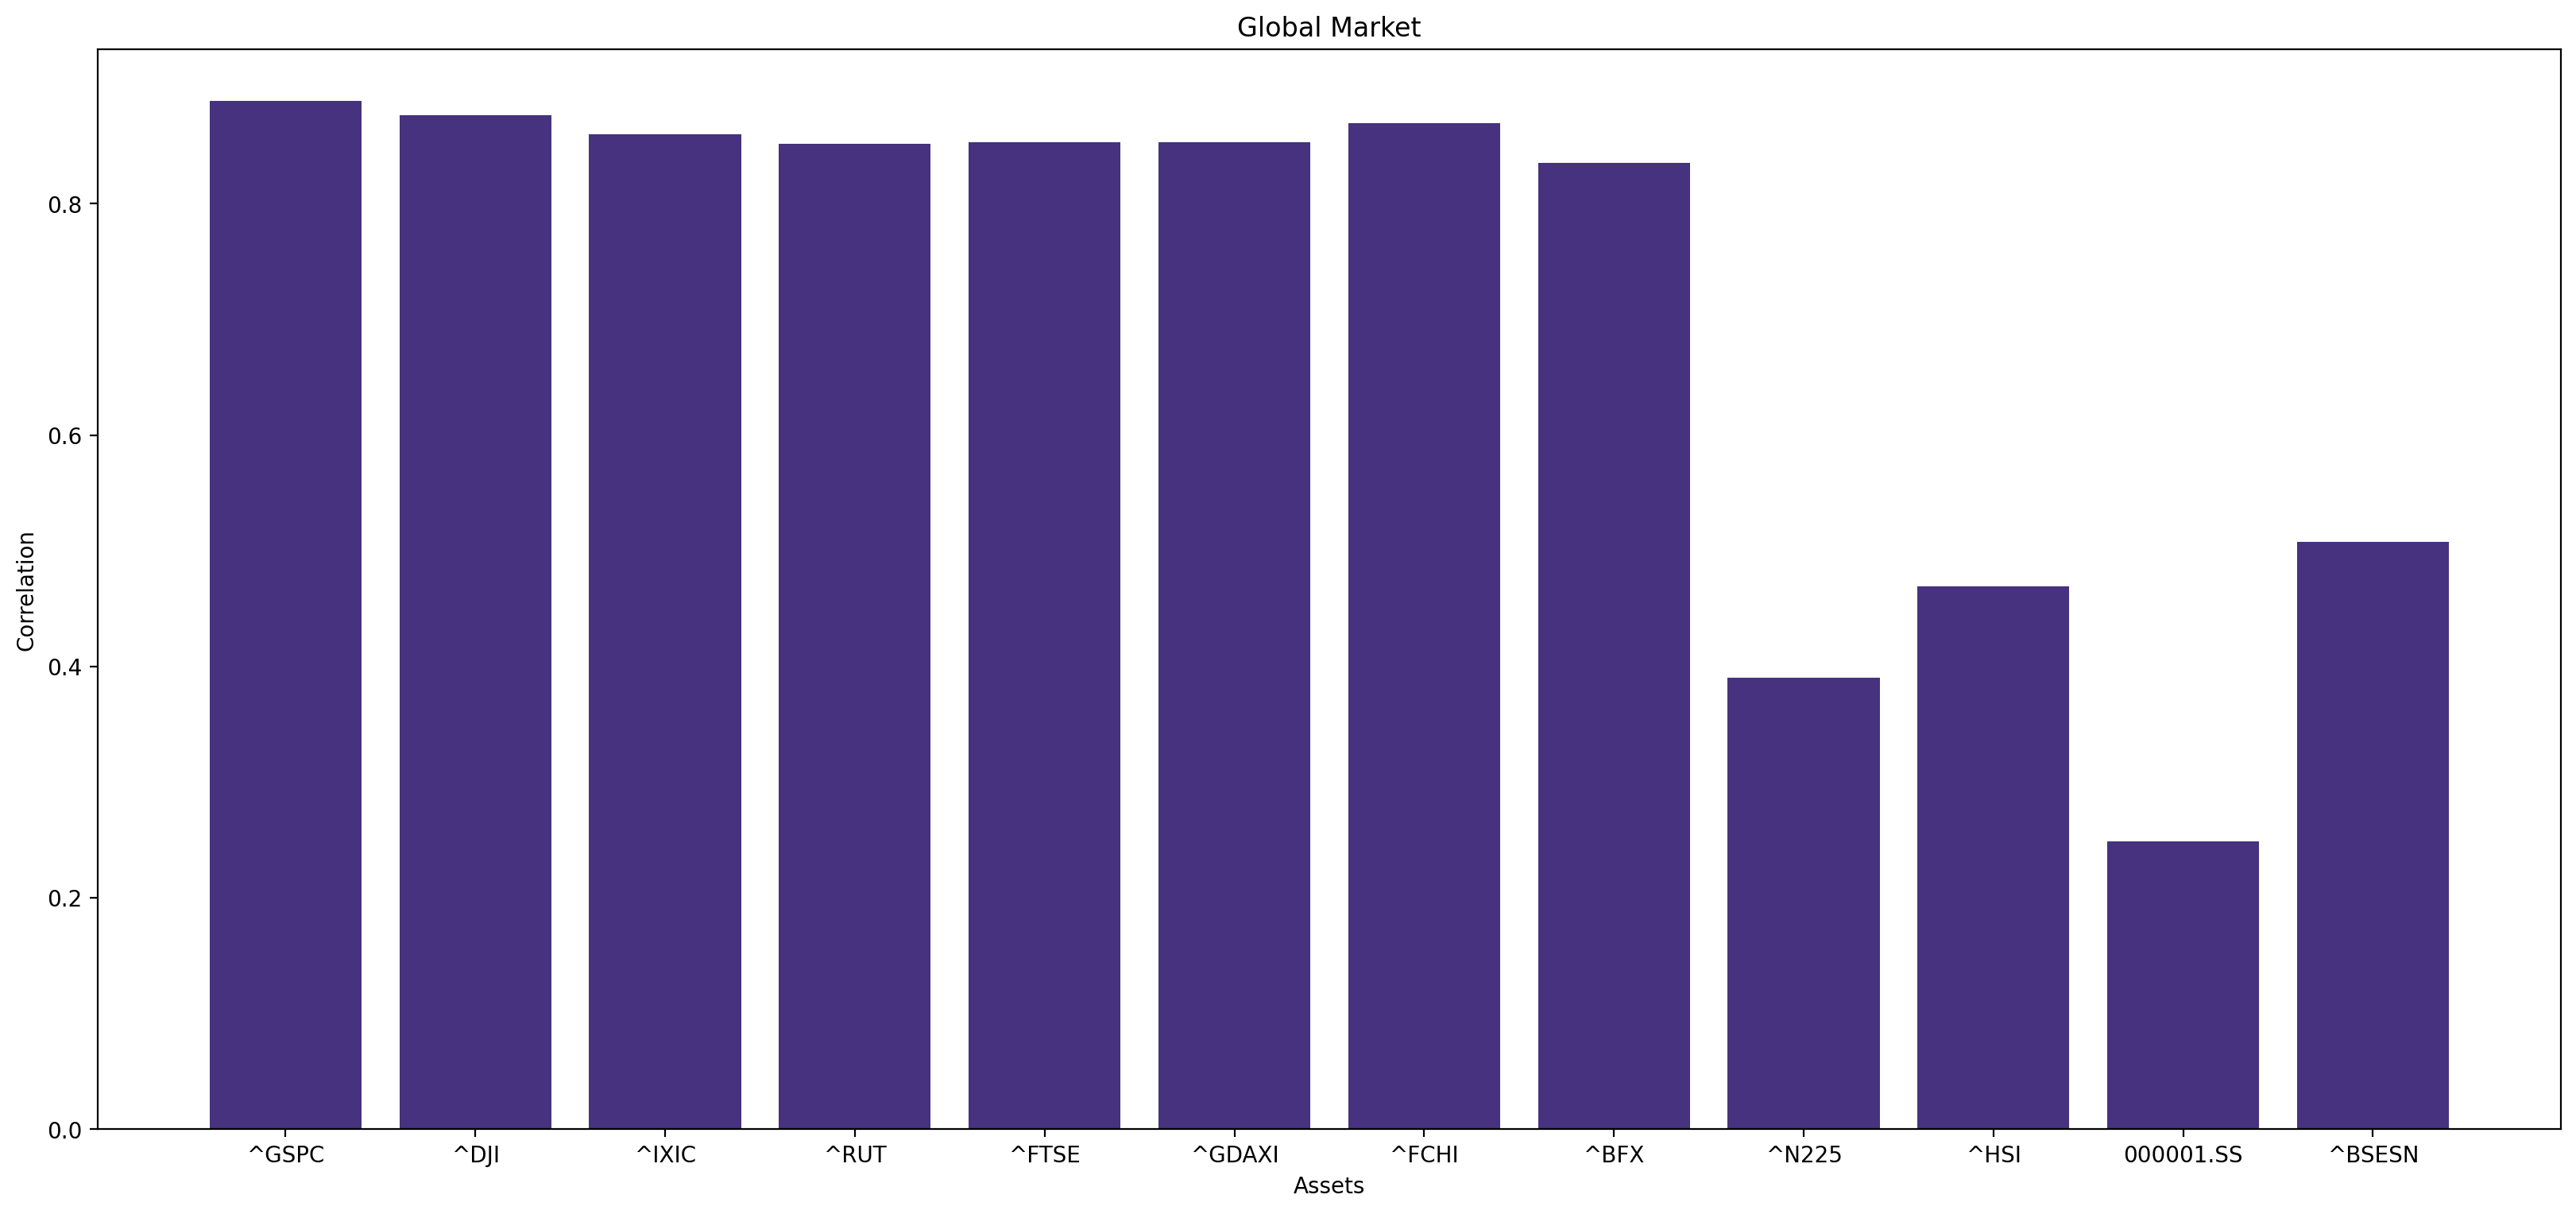

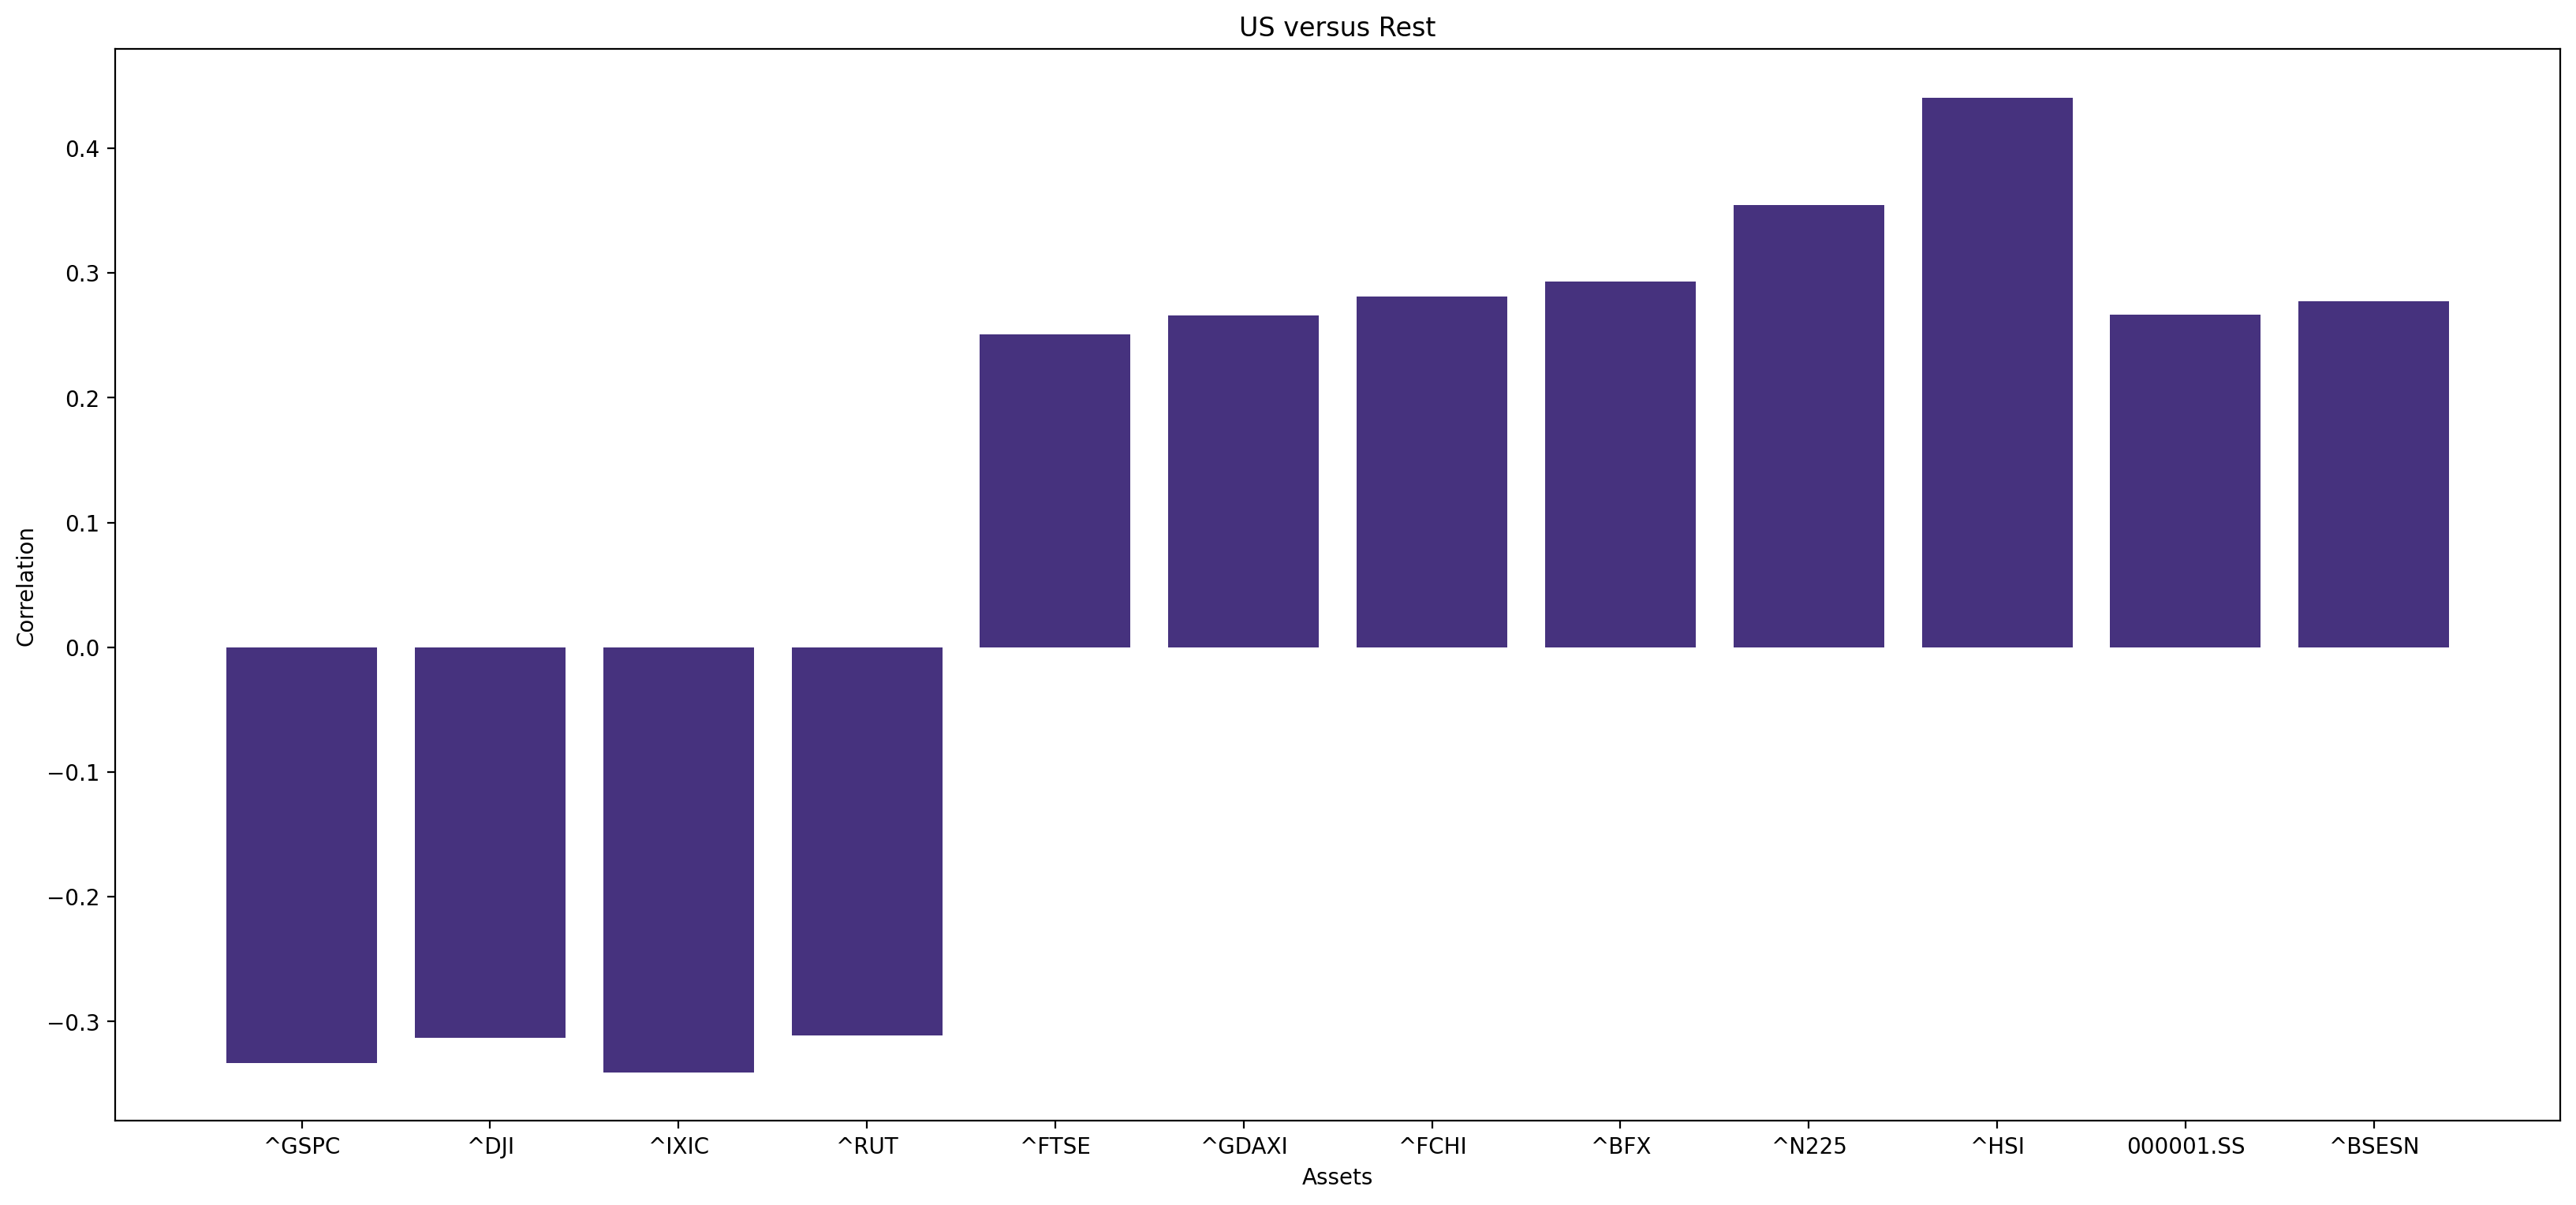

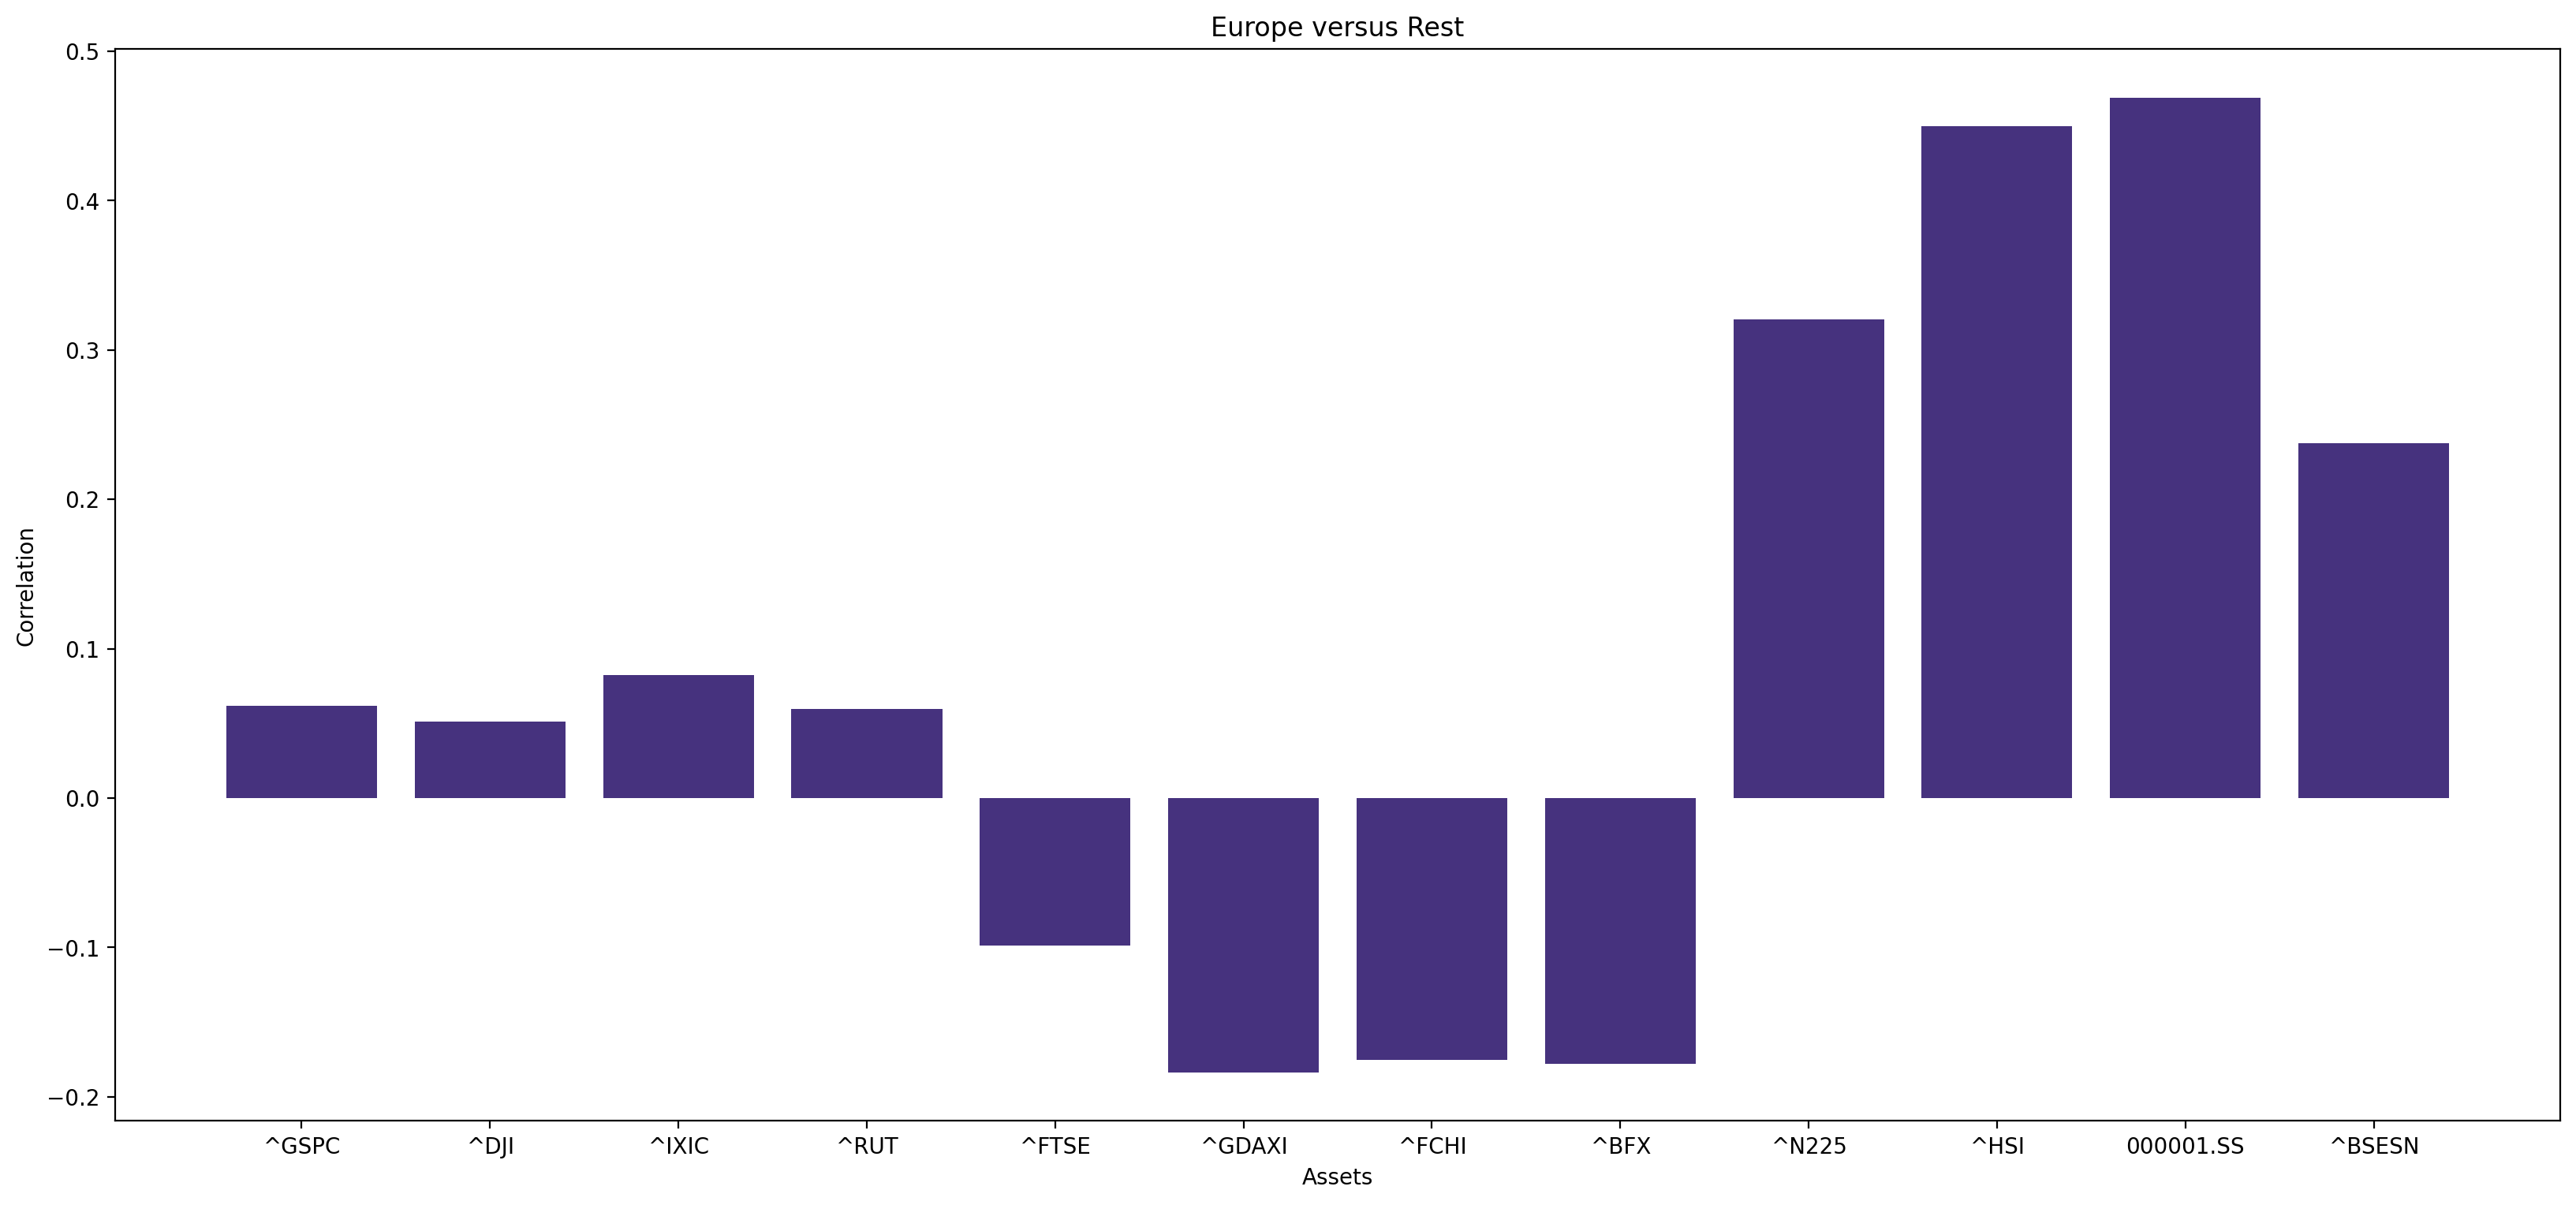

In [ ]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis().fit(StandardScaler().fit_transform(dataset))

component_labels = {
    0: f'Global Market',
    1: f'US versus Rest',
    2: f'Europe versus Rest',
}

for n, component in enumerate(fa.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

Indeed we see a similar result as with PCA; the first is almost the same. A first difference we can notice is in the second component; whereas in the second component Europe barely correlates, in the second factor it does.

Another notable difference is the fact that FA is able to capture all variance in only three underlying factors.

In [ ]:
(fa.components_.sum(axis=1) != 0).sum()

3

# Copulas

In this section, we will go into detail about copulas. A copula of $(X_1, ..., X_d)$ is the distribution function of $(F_1(X_1). ..., F_d(X_d))$ and it can be named as the dependence structure of $F$. So, it is a multivariate CDF where marginals for all variables are Uniform `[0,1]`. Copulas says something about the dependence of certain pairs of assets. By using copulas, one can model dependence in risks but in a more sophisticated approach than correlations or with the Multivariate Normal distribution.  

Although it is possible to go into a higher dimensional setting, we will focus our research on the two dimensional setting. 

We will looked at a variety of copulas. Two well known copulas are the Gaussian and Student's $t$ copulas. The tail dependence for the normal copula can be considered as zero and hence there can be concluded that it is not very suitable for modelling tail dependence. However, a Student's $t$ distribution with heavy tails (i.e. with relatively low degrees of freedom) does show some tail dependence. These elliptical copulas are related to correlation. However, the correlation can be the same between the two, although the tail dependence is completely different.

Other copulas which belong to the *Archimedean copulas* are the Gumbel copula, Clayton copula and Frank copula. These copulas are not relation to correlation.

The Gumbel copula is defined by: 
$$C_{\beta}^{Gu} (u_1, u_2) = exp \Bigg(-\Big((-log u_1)^{\beta} + (-log u_2)^{\beta} \Big) ^{1/\beta} \Bigg).$$
If $\beta$ is equal to `1`, it shows independence and if $\beta$ goes to infinity it has comonotonicity. This copula models upper (or right) tail dependence and it is a good model if losses are large simultaneously between assets.

The Clayton copula is defined by:
$$C_{\beta}^{Cl}(u_1,u_2) = \Big(u_1^{-\beta} + u_2^{-\beta} - 1\Big)^{-1/\beta}.$$
If $\beta$ approaches zero, it becomes independent and again, if it converges to infinity, it shows comonotonicity behaviour. The Clayton copula model has a lower (or left) tail dependence and it is convenient for analysing returns. 

The Frank copula models upper as well as lower tail dependence. It is defined on the interval $\beta\in \mathbb{R} /\{0\}$ and the equation is given by:

$$C_{\beta}^{Fr} = \frac{1}{\beta} log [1+ \frac{(exp(-\beta u_1)-1)(exp(-\beta u_2) -1)}{exp(-\beta) -1}].$$

It can be derived how the extreme events, i.e. when converging to plus and minus infinity as well as converging to 0, behaves. If we converges to zero, the copula approaches the product of $u_1$ and $u_2$, which implies independence. If we converge to infinity, the copula will be equal to the minimum of these two values. Hence, in this case it implies comonotonicity, or in other words, perfect dependence. And the last case is when it approaches minus infinity, then it goes to $max\{u_1 + u_2 -1,0\}$, which implies countermonotonicty, or put differently perfect negative dependence. 

So, the copulas we will consider are the Gaussian copula, the Student's $t$ copula, Gumbel copula, Clayton copula and Frank copula. 

To find out which asset pairs fit to which copula family the best, we try to fit every possible pair to every possible family and create a heatmap of the *log-likelihood*. The higher this number, the better the pair's distributions match.

In [ ]:
from itertools import combinations

# https://github.com/vinecopulib/pyvinecopulib
import pyvinecopulib as pv

# pyvinecopulib expects data to be pseudo-observations
# borrowing computer from https://github.com/DanielBok/copulae
from copulae.core import pseudo_obs

results = []
for pair in list(combinations(dataset.columns, 2)):

    data = pseudo_obs(dataset[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    pair_results = {'pair': pair}
    for family in family_set:
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results[family.name.capitalize()] = copula.loglik()
    results.append(pair_results)
    
results = pd.DataFrame(results).set_index('pair')

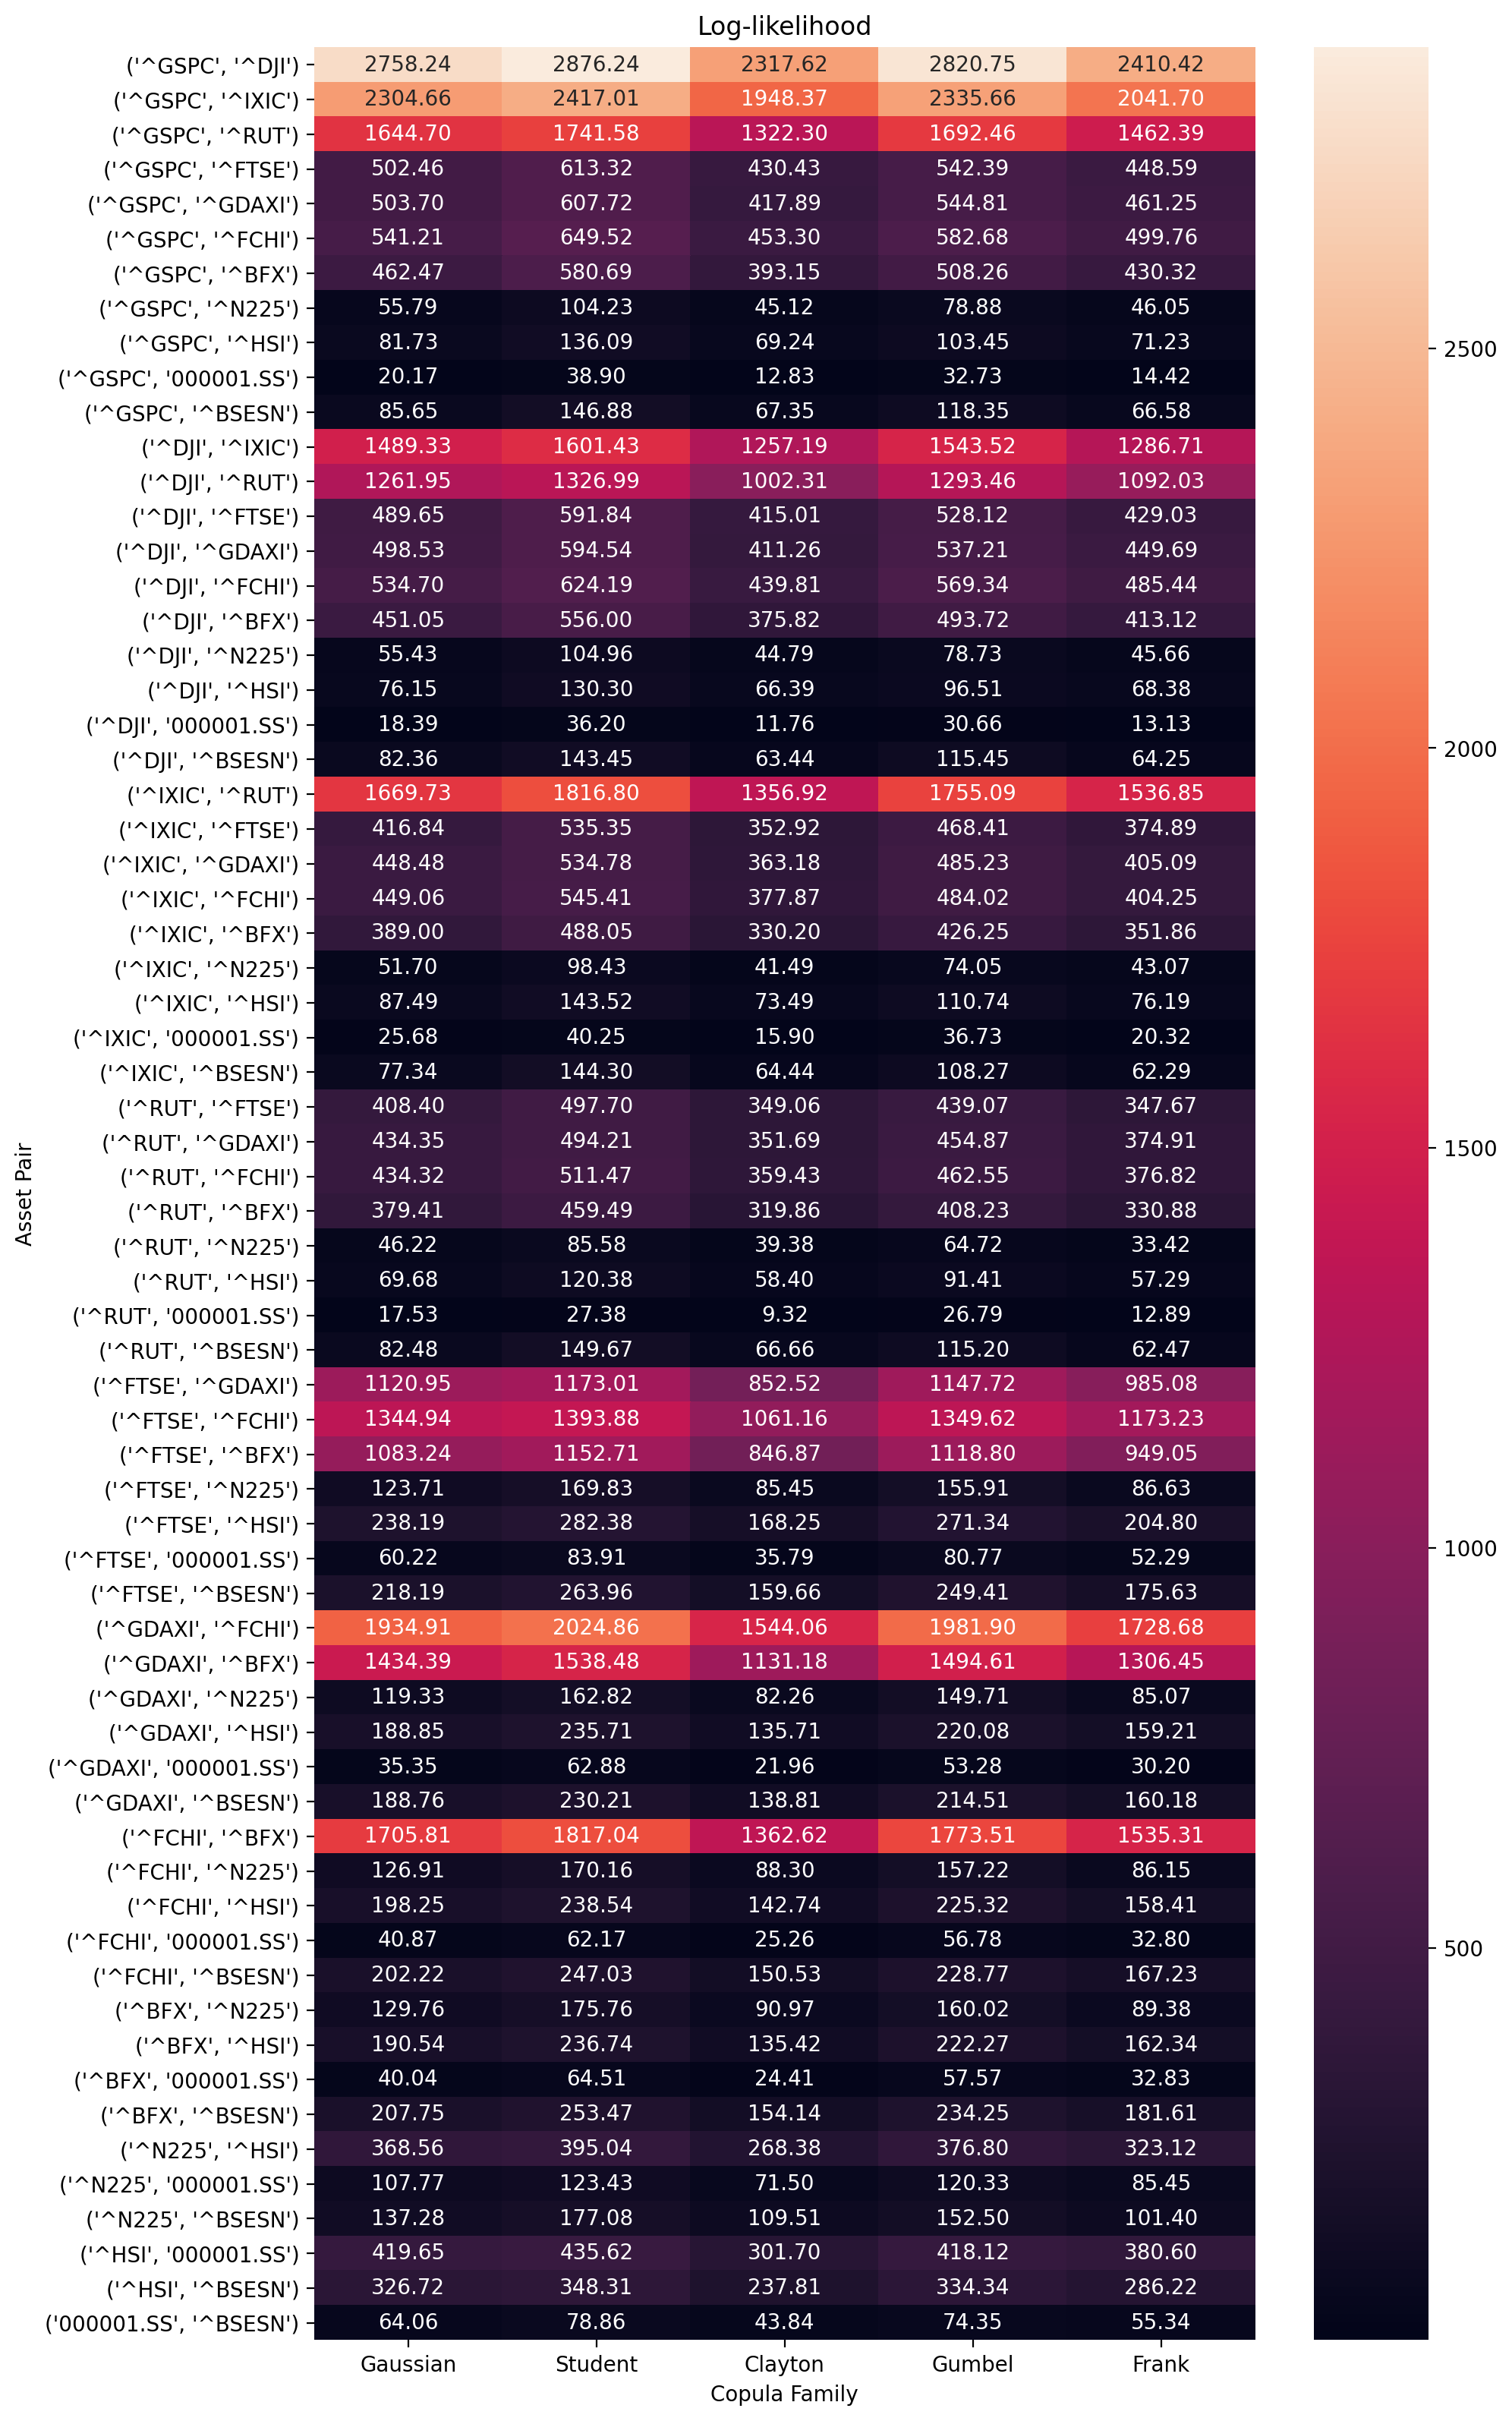

In [ ]:
plt.figure(figsize=(10,20))
sns.heatmap(results, annot=True, fmt='.2f')
plt.title('Log-likelihood')
plt.xlabel('Copula Family')
plt.ylabel('Asset Pair')
plt.show()

In [ ]:
results.idxmax(axis=1).value_counts()

Student    66
dtype: int64

We can observe a couple of interesting things. First, the Student's t-distribution copula provides the highest log-likelihood in all 66 cases. Second, we see that certain pairs have a noteably high log-likelihood across all copula families. In all cases these are pairs belonging to the same continent. Lastly it is surprising to see that this phenomenon is much weaker for the Asian indices.

Let's compare the copulas of the best and worst matching pairs.

In [ ]:
def z_pdf(copula, x1, x2, zclip=30):
    """computes third dimension using pdf of fitted copula
    very rudimentary (slow!) implementation which could probably be vectorised
    inspired by https://github.com/blent-ai/pycopula/blob/master/pycopula/visualization.py
    """
    
    x1 = np.sort(x1)
    x2 = np.sort(x2)
    z= []
    for i in range(len(x1)):
        row = []
        for j in range(len(x2)):
            row.append(min(copula.pdf([[x1[i], x2[j] ]])[0], zclip))
        z.append(row)

    return x1, x2, np.asarray(z)

best_pair = results.max(axis=1).idxmax()
best_data = pseudo_obs(dataset[[best_pair[0], best_pair[1]]])

best_copula = pv.Bicop(family=pv.BicopFamily.student)
best_copula.fit(best_data)

x1, x2 = best_data[:, 0], best_data[:, 1]
x1_s, x2_s, z = z_pdf(best_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

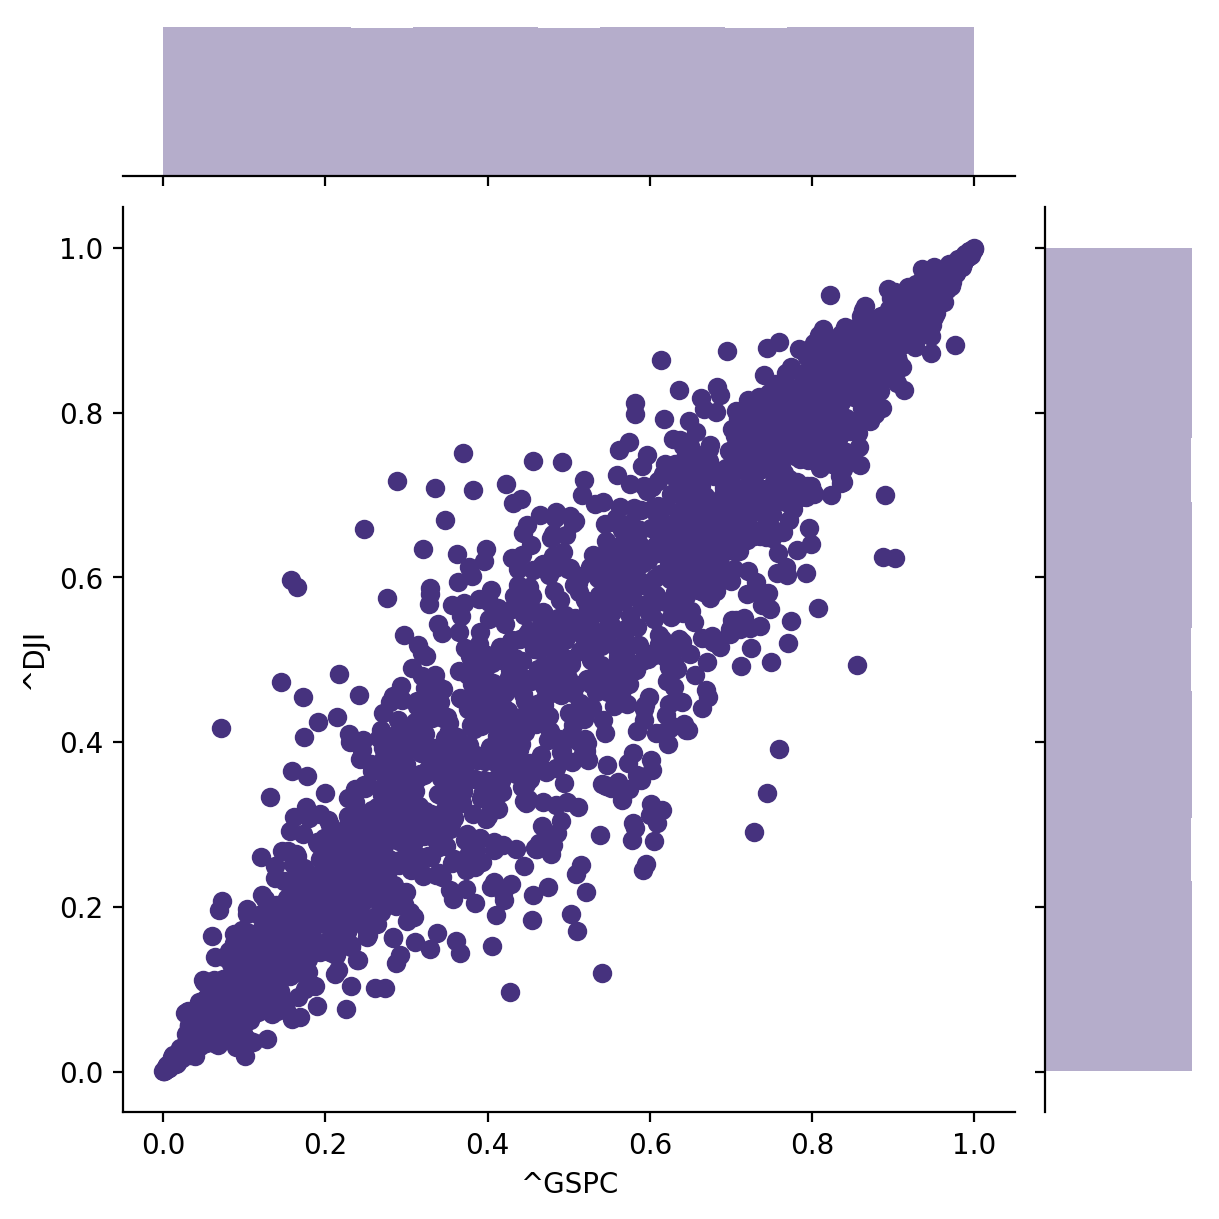

In [ ]:
sns.jointplot(x1, x2, kind='scatter').set_axis_labels(best_pair[0], best_pair[1])
plt.show()

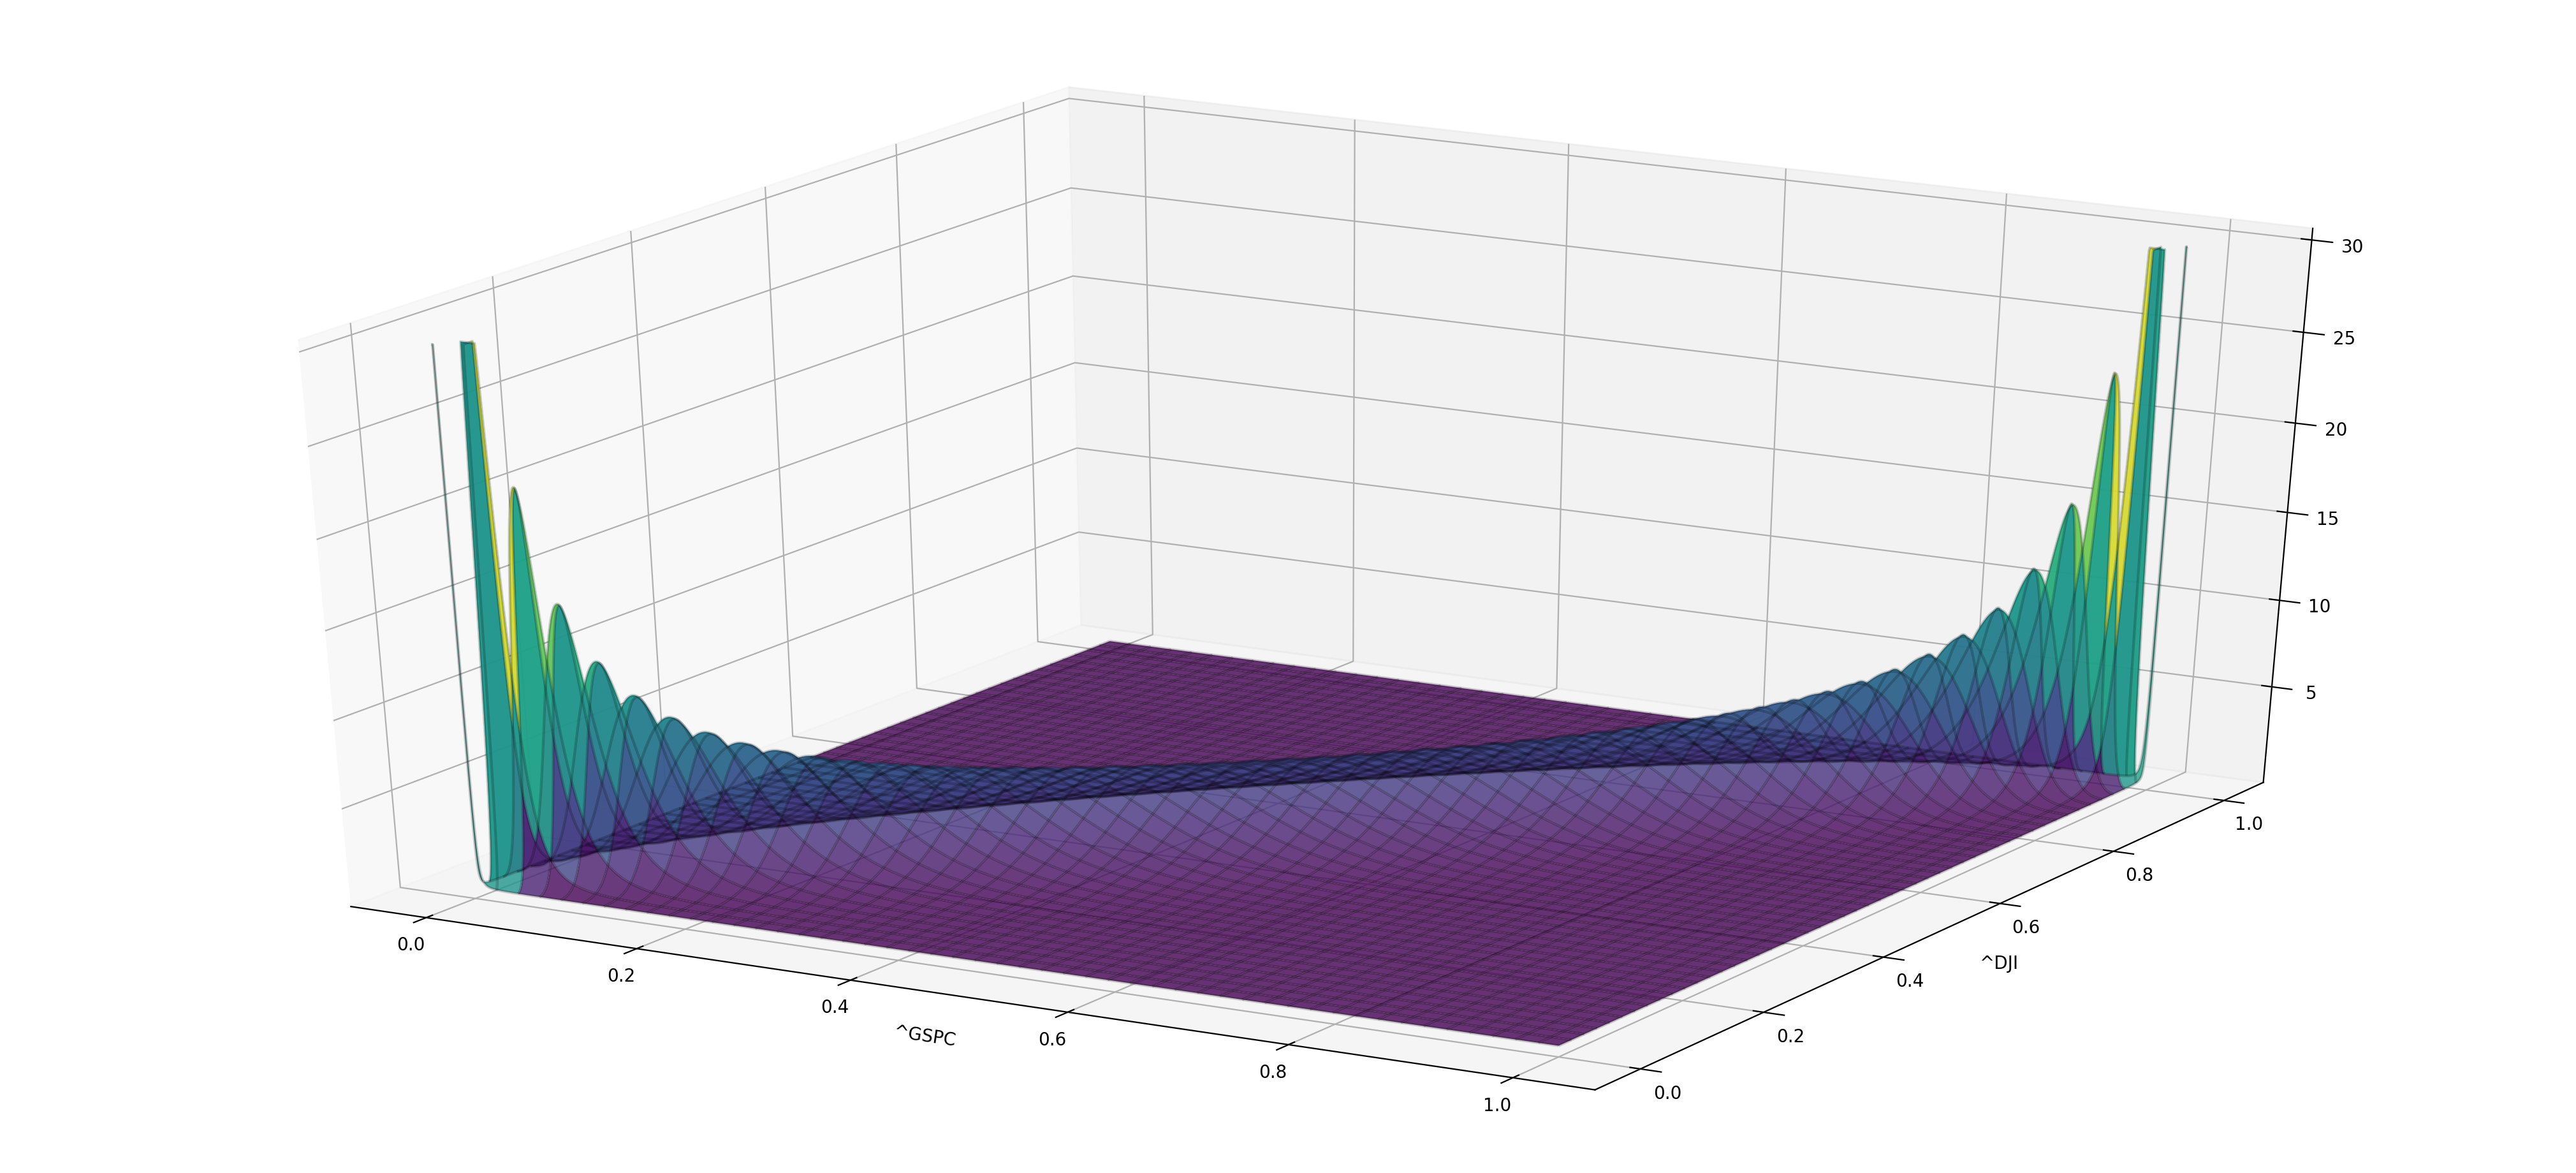

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='viridis')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
ax.set_xlabel(best_pair[0])
ax.set_ylabel(best_pair[1])
plt.show()

These two figures show a scatter and density plot of the best pair; `('^GSPC', '^DJI')`. A tail dependence can be observed and it can be considered as symmetric. The density is shown in the second figure. Note that it is on the interval `[0,1]` since the marginals need to be uniform. The tails had to be capped at `30` which confirms the heaviness of the tails. Also, remark a significant amount of the mass is in the tails.

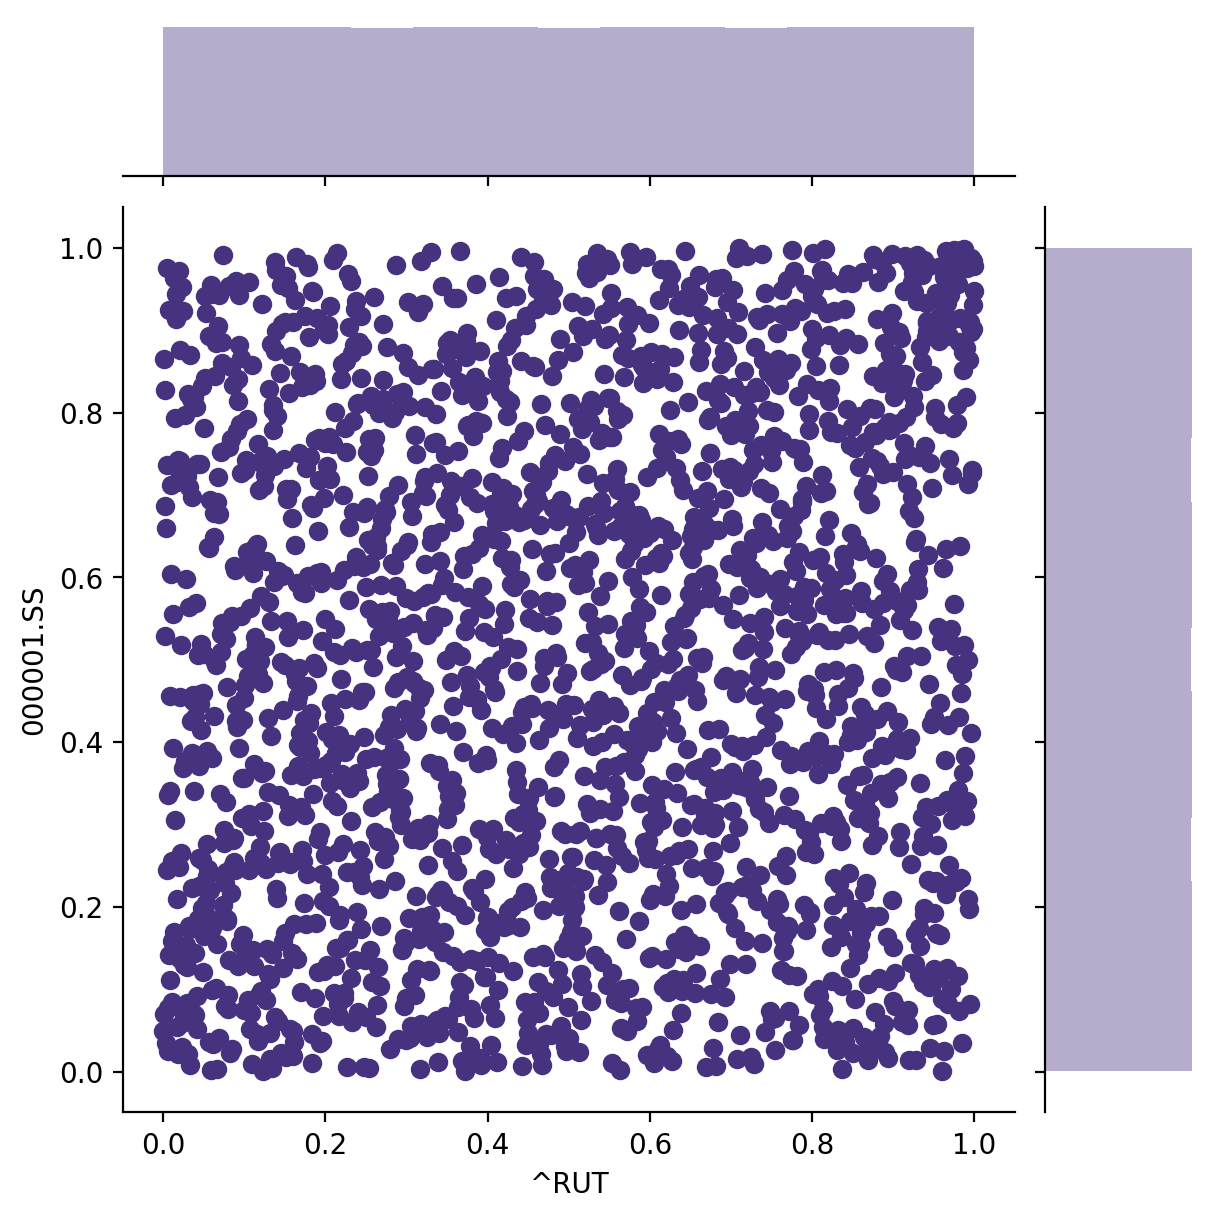

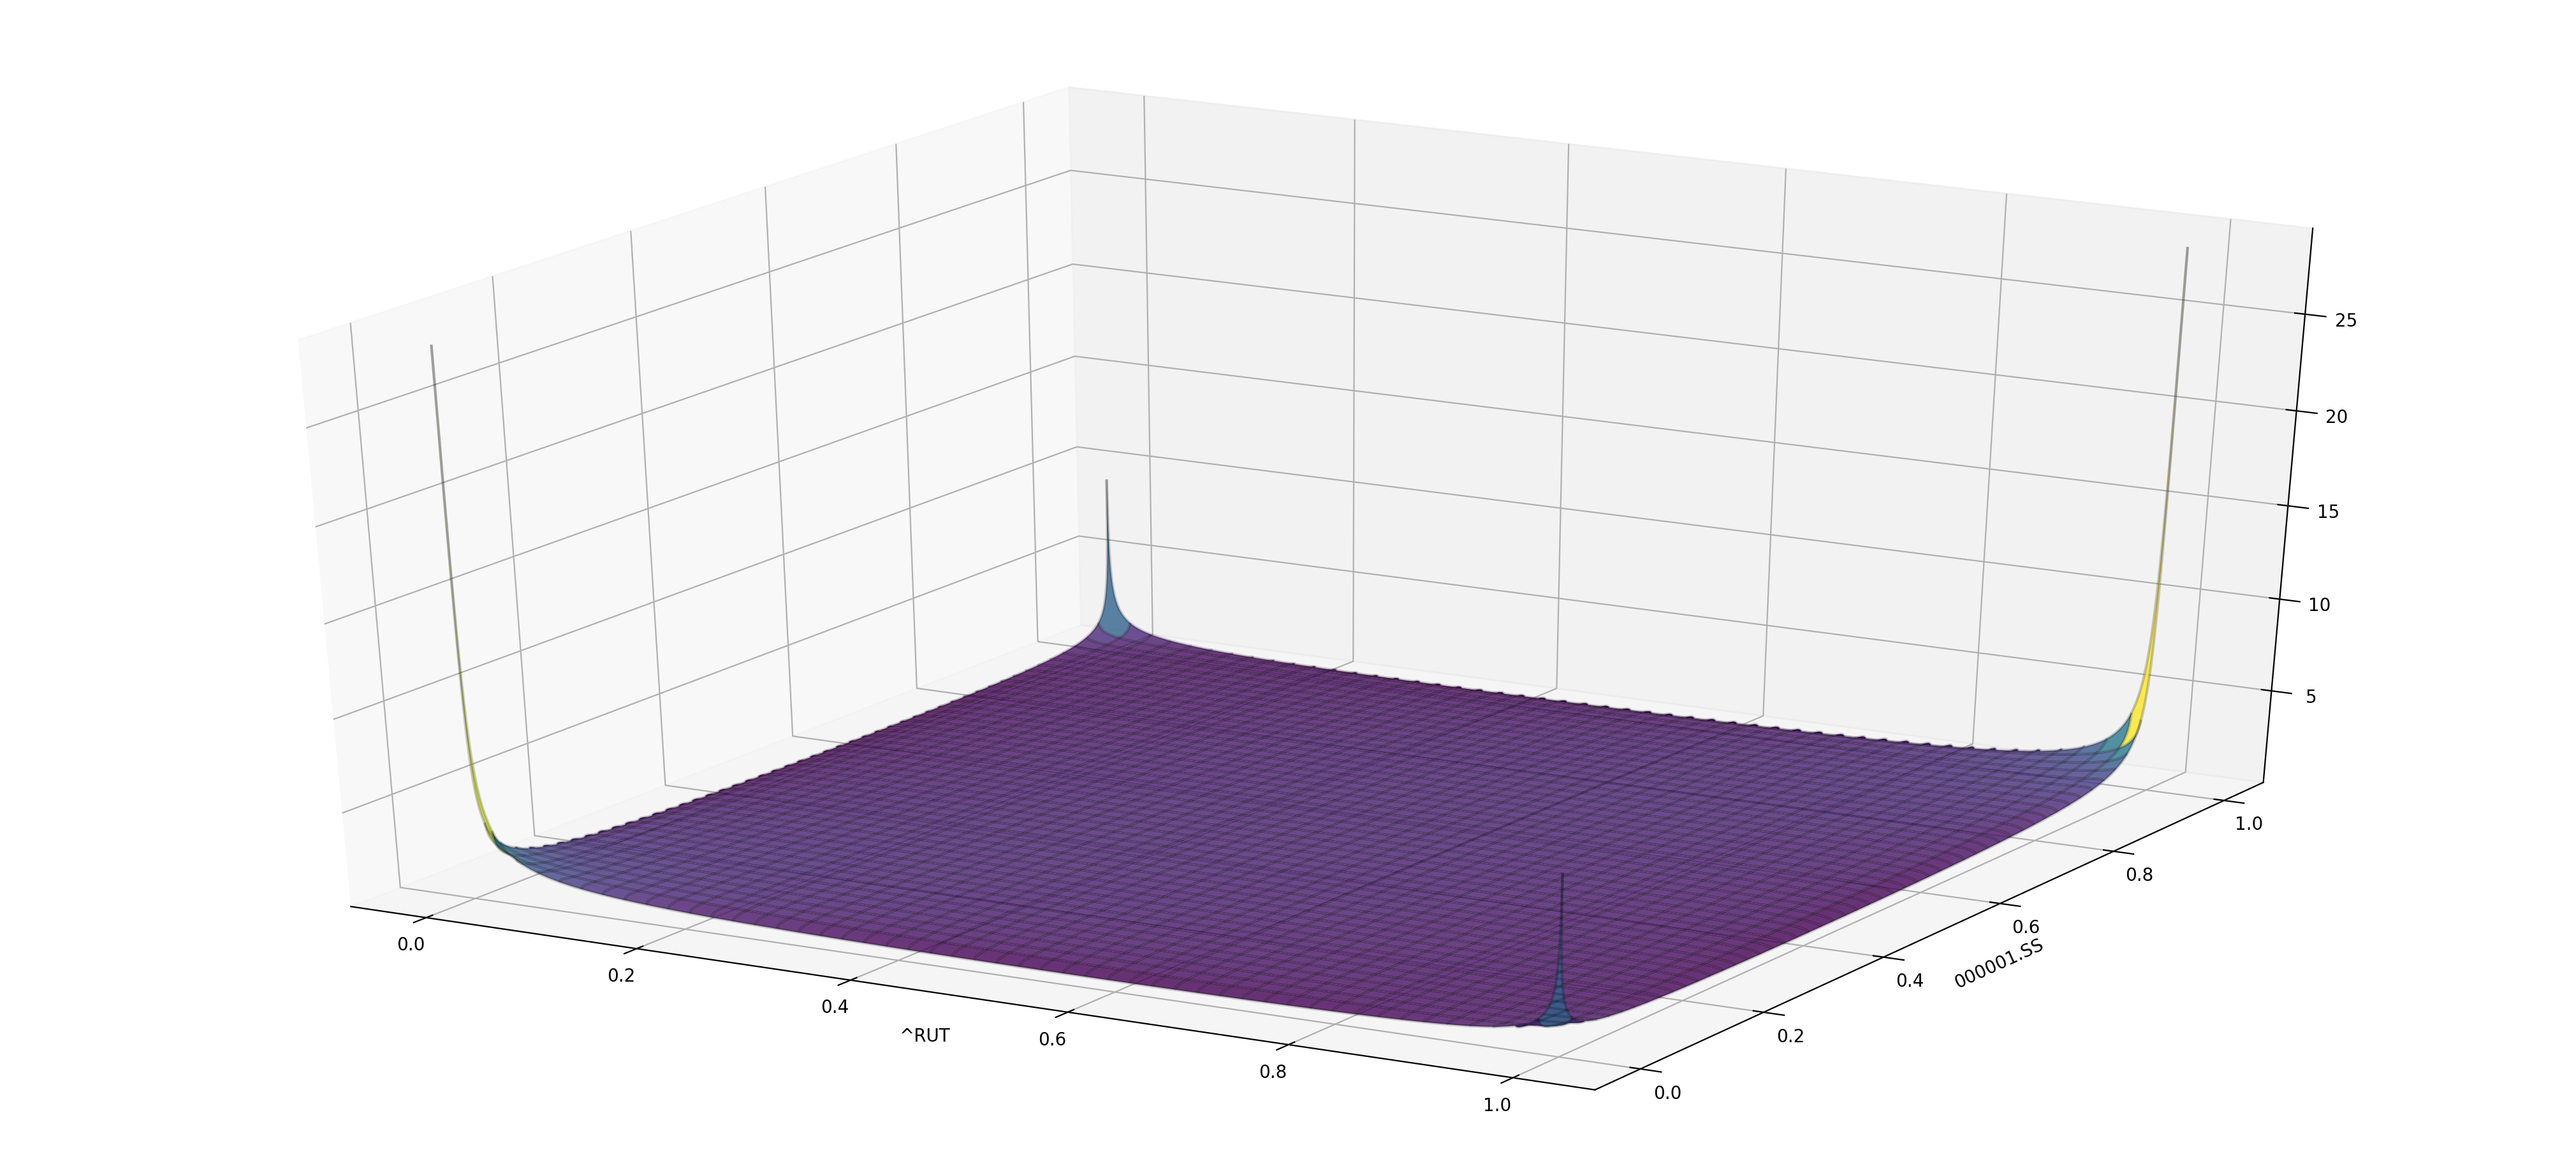

In [ ]:
worst_pair = results.max(axis=1).idxmin()
worst_data = pseudo_obs(dataset[[worst_pair[0], worst_pair[1]]])

worst_copula = pv.Bicop(family=pv.BicopFamily.student)
worst_copula.fit(worst_data)

x1, x2 = worst_data[:, 0], worst_data[:, 1]
x1_s, x2_s, z = z_pdf(worst_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

sns.jointplot(x1, x2, kind='scatter').set_axis_labels(worst_pair[0], worst_pair[1])
plt.show()

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='viridis')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
ax.set_xlabel(worst_pair[0])
ax.set_ylabel(worst_pair[1])
plt.show()

The latter two figures show the scatter and density plot of the pair with the lowest log-likelihood; `('^RUT', '000001.SS')`. In the scatter plot, there is not a clear pattern. From the density plot can be concluded that the tails are relatively high, but smaller than before. And, in addition, there barely any mass in the tails, i.e. the tails only exist in the most extreme corners.

Now let us look at some parameters of certain copulas. We have made a selection of some interesting pairs and explain their parameters below.

In [ ]:
def print_parameters(pair):
    results = []
    data = pseudo_obs(dataset[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    print(pair)
    for family in family_set:
        pair_results = {}
        pair_results['family'] = family.name.capitalize()
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results['rho/beta'] = copula.parameters[0][0]
        try:
            pair_results['v'] = copula.parameters[1][0]
        except:
            pair_results['v'] = pd.NA
        pair_results['log-likelihood'] = copula.loglik()
        results.append(pair_results)
        
    return pd.DataFrame(results).set_index('family')


print_parameters(('^GSPC', '^DJI'))

('^GSPC', '^DJI')


rho/beta        v  log-likelihood
family                                      
Gaussian   0.963259     <NA>     2758.243166
Student    0.966528  5.00053     2876.242046
Clayton    6.156537     <NA>     2317.618844
Gumbel     5.803195     <NA>     2820.754030
Frank     19.766861     <NA>     2410.416844

In the table above, the copulas' parameters are shown for the S&P 500 and Dow Jones index (`('^GSPC', '^DJI')`). We observe that, as mentioned before, the Student's $t$ copula has the highest log-likelihood and hence is the most suitable. For the correlation parameters, i.e. for Gaussian and Student-t distribution, we can observe a very similar value. However, the Student's $t$ is better. This value is very close to one, which indicates a high correlation. This can be due to the fact that both belong to the USA. The degrees of freedom is not significantly very low or high and has a value equal to `5.0`.

The $\beta$ parameter of Gumbel and Clayton are not very close to one and zero, respectively, which should imply independence. Similar, the Frank parameter is relatively high, which also implies that it is not close to independence. 

We could compare the same first asset, i.e. S&P 500, with other assets. The correlation stays relatively high for assets on the same continent. If we compare it with European countries, the correlation declines. But it declines even more for assets belonging to the Asian.

In [ ]:
print_parameters(('^RUT', '000001.SS'))

('^RUT', '000001.SS')


rho/beta        v  log-likelihood
family                                     
Gaussian  0.129397     <NA>       17.534947
Student   0.119720  8.80553       27.382689
Clayton   0.106005     <NA>        9.321841
Gumbel    1.091804     <NA>       26.790948
Frank     0.681857     <NA>       12.885485

In [ ]:
print_parameters(('^HSI', '000001.SS'))

('^HSI', '000001.SS')


rho/beta       v  log-likelihood
family                                    
Gaussian  0.575492    <NA>      419.649063
Student   0.576128  8.2731      435.620580
Clayton   0.826433    <NA>      301.704540
Gumbel    1.595810    <NA>      418.122920
Frank     4.042582    <NA>      380.595135

Next, we have two tables given of asset pairs which include SSE Composite Index (`000001.SS`). In the first table, the results are shown for this asset and the Russell 2000 `('^RUT')`. For the Student's $t$ copula, there can be concluded that the correlation is relatively small. This could be declared by the fact that these are assets from different continents. If we neglect the fact that the Student's $t$ copula is the best and focus on the $\beta$ parameters of the Gumbel and Clayton copula, there could be indicated that these are close to one and zero, respectively, which implies independence. The Frank parameter is also relatively close to zero. As mentioned before this would also imply independence.

Between the Hang Seng Index and the SSE Composite Index, this conclusion is less observable. Here, the correlation is still not very big, but significant higher. Also, the parameters for the Gumbel, Clayton and Frank copula are higher than before. This could be declared by the fact that Hong Kong belongs, officially, to China.

In [ ]:
print_parameters(('^IXIC', '^FTSE'))

('^IXIC', '^FTSE')


rho/beta       v  log-likelihood
family                                    
Gaussian  0.573927    <NA>      416.839141
Student   0.564403  2.4708      535.346343
Clayton   0.954252    <NA>      352.918149
Gumbel    1.653572    <NA>      468.411999
Frank     4.108701    <NA>      374.894285

Lastly, we will look at the parameters of an asset pair with the lowest degrees of freedom (for Student's $t$ copula). This asset pair, within the considered assets, was between Nasdaq and FTSE 100. We find that the log-likelihood for the Student's $t$ copula is significantly higher than for the other copulas. The parameters for the Gaussian and Student's $t$ are very similar. The degrees of freedom parameter equals approximately `2.47`, which indicates very fat tails.

# Extreme Value Theory (EVT)

The final part of this assignment will be about Extreme Value Theory. This is a theory that analyses the possible distributions of extreme (tail events). It is about events which can occur, but are rarely happened before (or even never happened). The question raises: How to predict such events? This is where Extreme Value Theory arose. It is developed by Tippet, Fisher, Gnedenko and Gumbel around 1950. 

First, we will identify the asset in our portfolio with the heaviest tails of returns. We do so by calculating the *kurtosis* of the distribution of daily returns for each asset.

Kurtosis is defined as the measure of extreme values present in a distribution's tail. The higher the number, the heavier the tail. Our implementation of `stats.kurtosis` uses Fisher's definition; meaning that a normal distribution will have a kurtosis of `0`.

In [ ]:
from scipy import stats

pd.DataFrame(
    {'Kurtosis': stats.kurtosis(dataset)},
    index=dataset.columns
).sort_values(by='Kurtosis')

Kurtosis
^HSI        2.824605
^N225       4.520563
000001.SS   5.147982
^BSESN      7.440792
^FCHI       7.894014
^GDAXI      8.170835
^IXIC       9.749259
^FTSE      10.207809
^RUT       11.324679
^BFX       12.562537
^GSPC      14.875981
^DJI       20.350689

Let us zoom in on the tails of both extremes (`^HSI` and `^DJI`) and confirm that `^DJI` indeed has the distribution with the tickest tails.

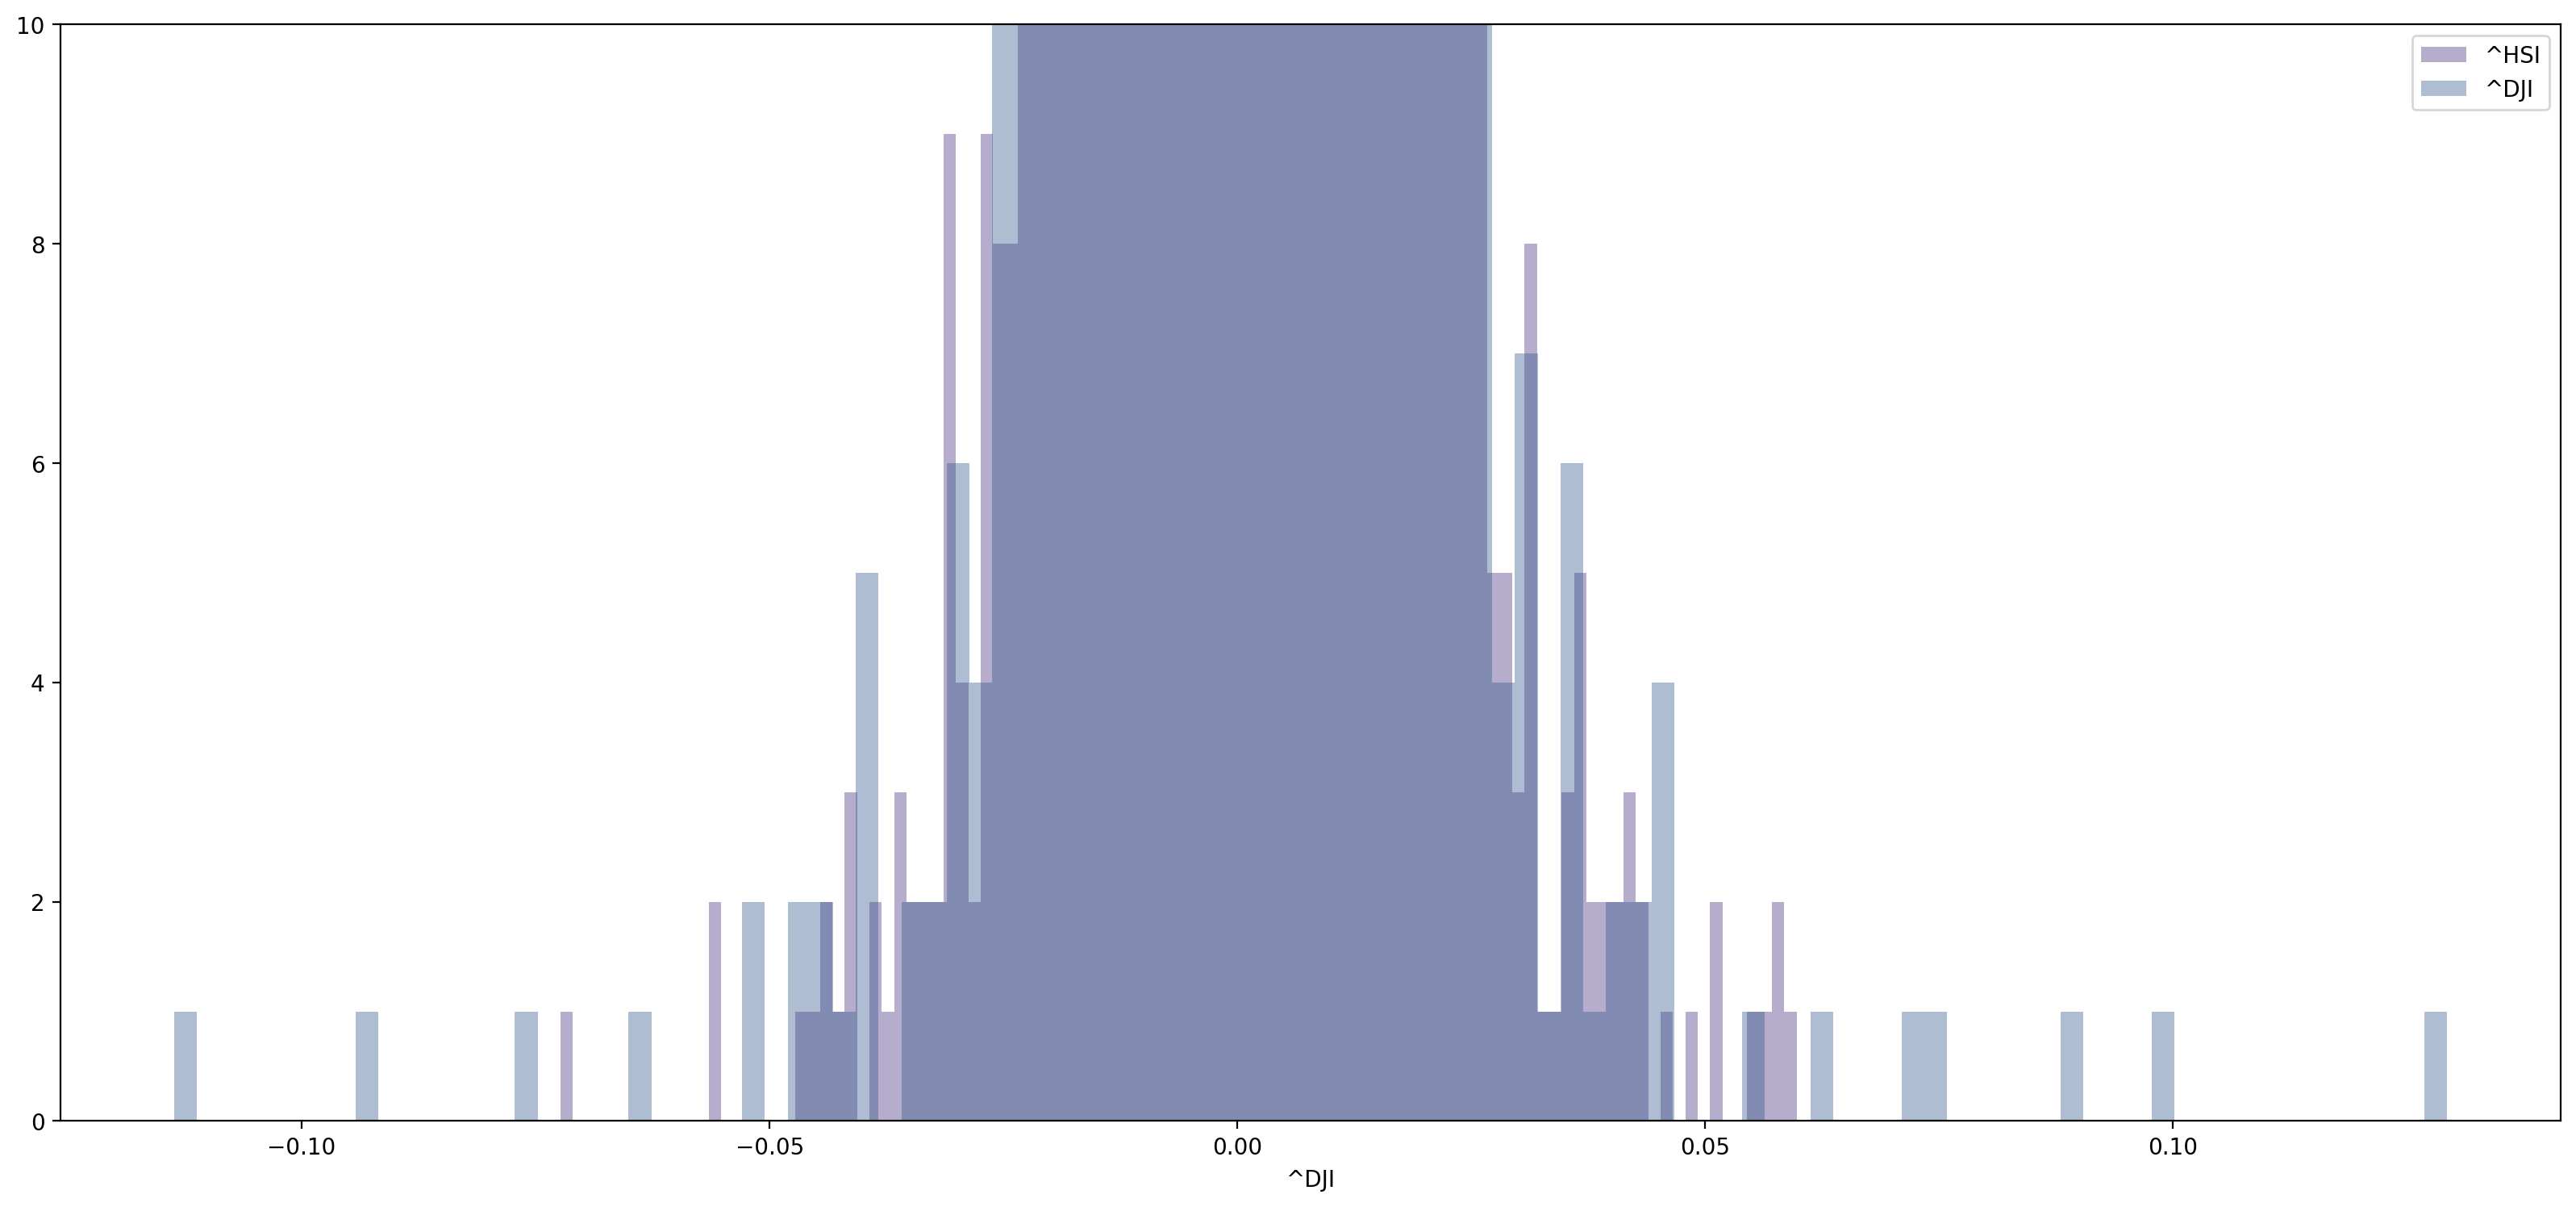

In [ ]:
sns.distplot(dataset['^HSI'], bins=100, kde=False, label='^HSI')
sns.distplot(dataset['^DJI'], bins=100, kde=False, label='^DJI')
plt.ylim(0, 10)
plt.legend()
plt.show()

We will follow the Peaks-over-Threshold method. This method will answer the question of how much a threshold can be exceeded given that the loss exceeds a certain threshold. We define $u$ as a high threshold and assume that the excess distribution has a distribution function $F_u(x)$. Extreme Value Theory propose to use the *Generalized Pareto Distribution* (GPD) as an approximation of $F_u(x)$. The GPD has distribution function:

  \begin{array}{lr}
    G_{\xi, \beta}(x) = 1-(1+\xi x/\beta)^{-1/\xi} & : \xi \neq 0\\
    G_{\xi, \beta}(x) = 1-exp(-x/\beta) & : \xi = 0.
  \end{array}

In the equation $\beta>0$, $x\geq0 $ if $\xi\geq0$ and $0\leq x\leq -\beta/\xi$ if $\xi<0$. Note that the $\xi$ parameter gives information about the heaviness of the tails. So, $\xi>0$ indicates a heavy tailed distribution.

The choice of the threshold is very important. There must be a balance between the threshold and the amount of data. This means that when one chooses a high threshold, this will result in a fewer amount of data, since less observations exceed the threshold. Since there is less data available in this case, the variance and uncertainty goes up. Contrary, if we choose a lower threshold, we would obtain more data which causes the variance to decline. However, the approximation of $F_u(x)$ by the above mentioned distribution is only accurate in the tails. So, it creates a bias. In short, there is a trade-off between the bias and the variance.

Our first attempt at defining the threshold is by plotting the shape parameter $\xi$ against various thresholds, together with it's confidence interval and amount of exceedances:

In [ ]:
from scipy.stats import genpareto

results = {}
for threshold in np.linspace(dataset['^DJI'].quantile(.9), dataset['^DJI'].quantile(.99), 1000):
    exceedances = dataset['^DJI'][dataset['^DJI'] > threshold]

    with np.errstate(divide='ignore', invalid='ignore'):
        xi, loc, scale = genpareto.fit(exceedances)
        results[threshold] = {
            'xi': xi,
            'std': genpareto.std(xi),
            'x': exceedances.size
        }

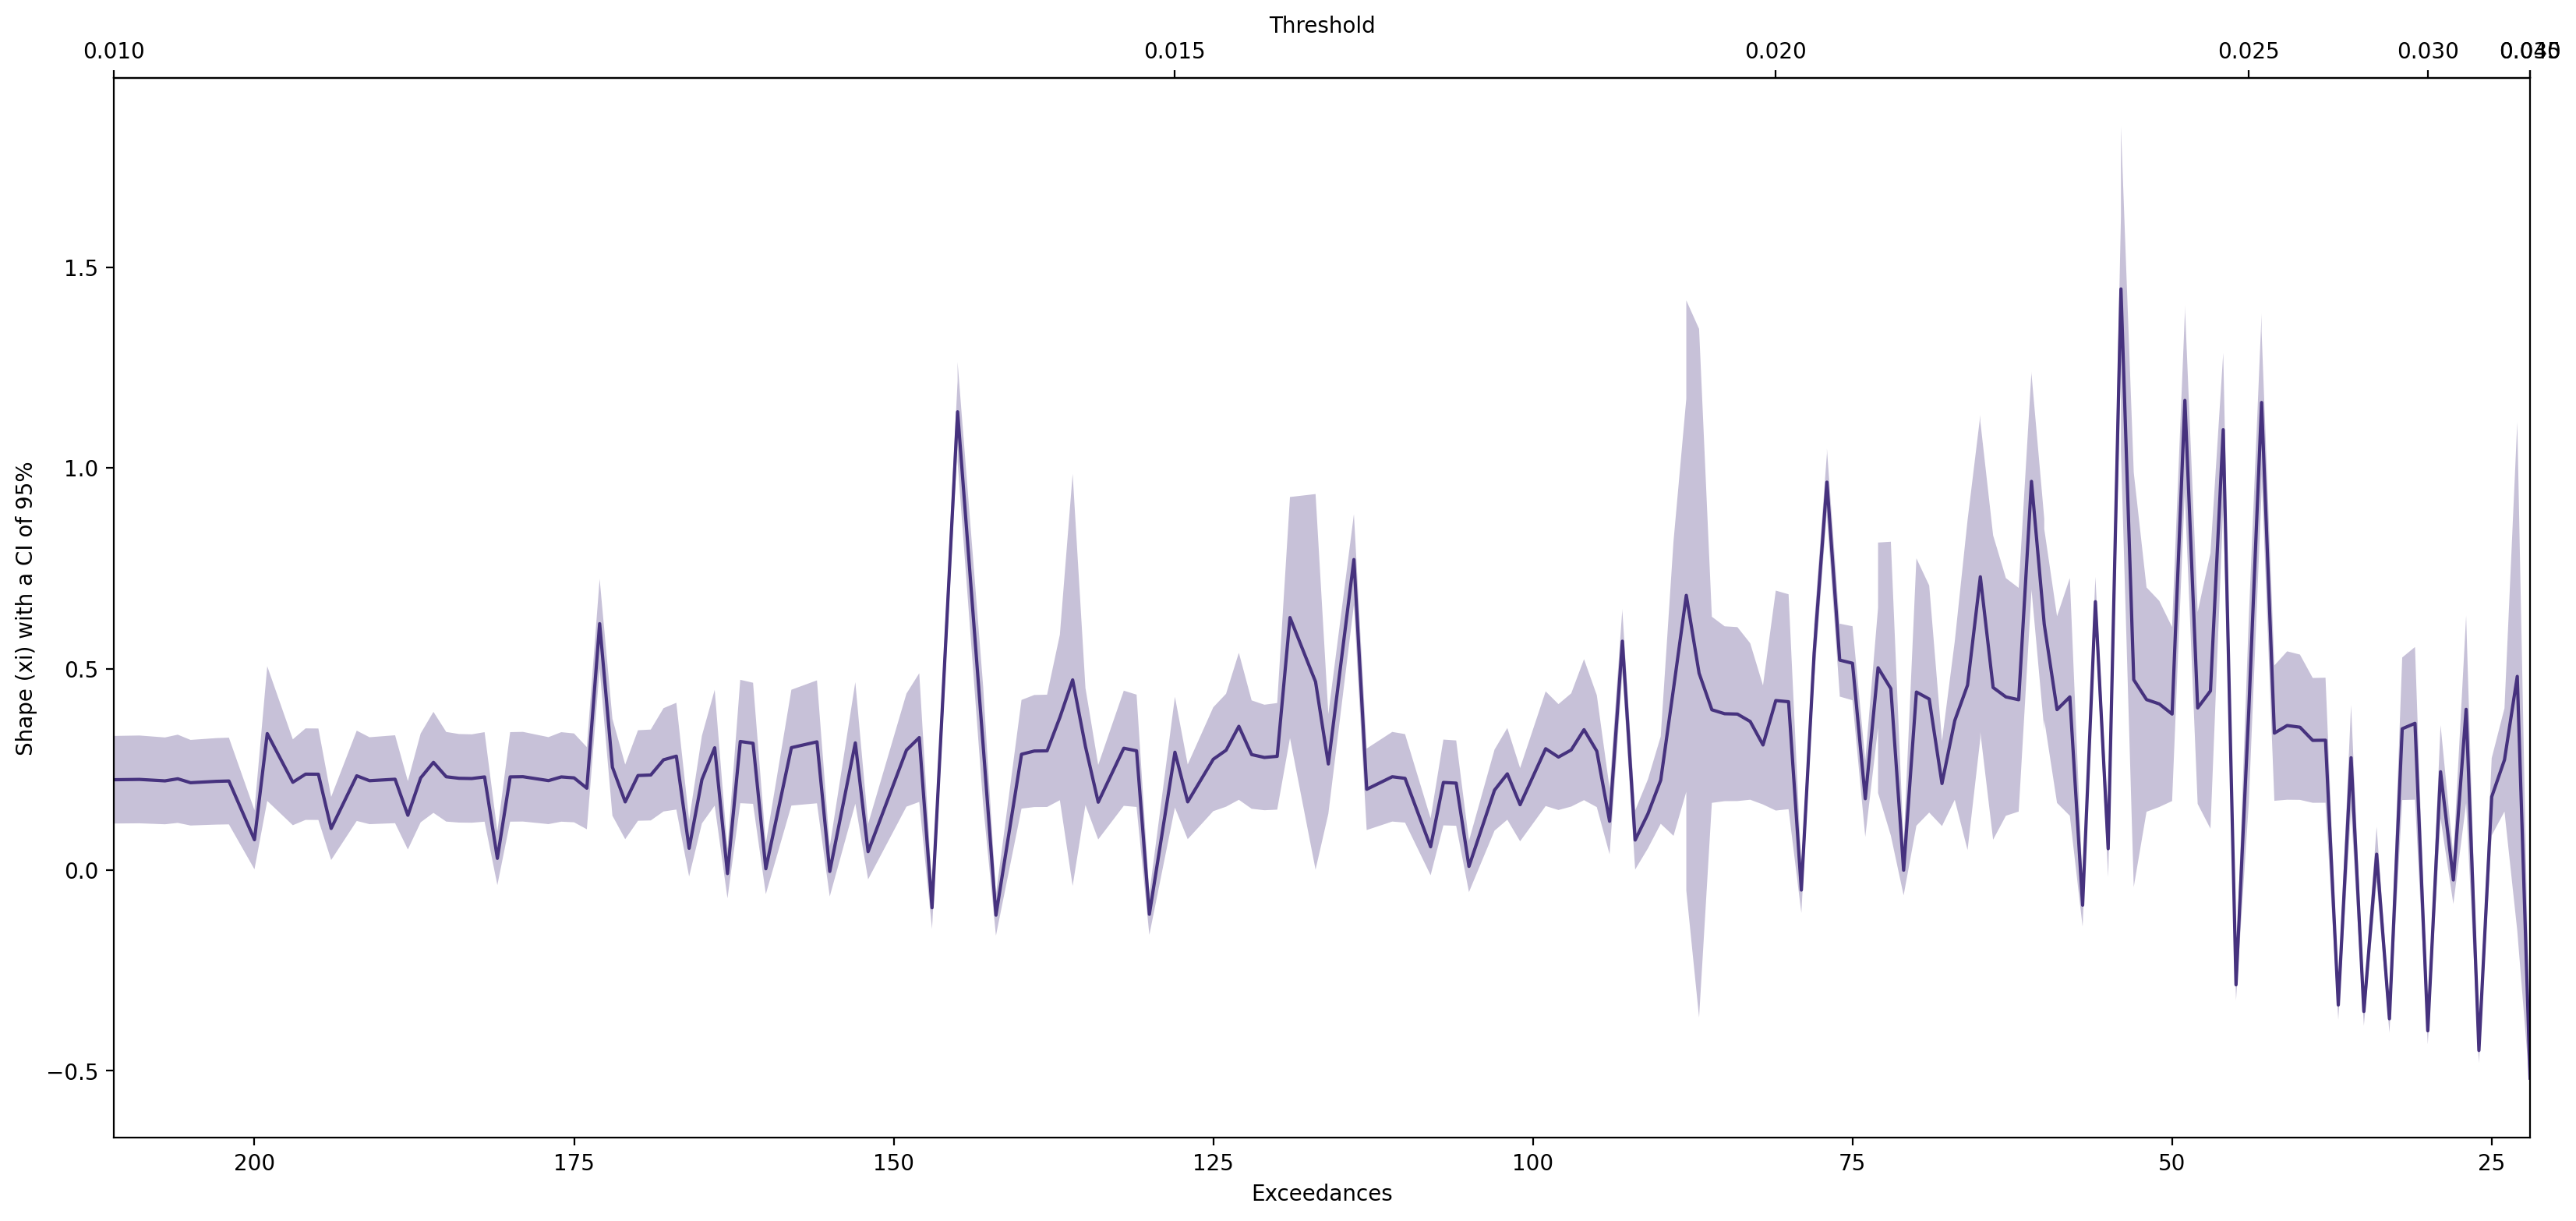

In [ ]:
from scipy.stats import norm

df = pd.DataFrame(results).T.replace(np.inf, np.nan)
df['std'].interpolate(inplace=True)

z = norm.ppf(1 - (.95 / 2))
upper = df['xi'] + z * df['std']
lower = df['xi'] - z * df['std']

def forward(x):
    return np.interp(x, df['x'], df.index)

def inverse(x):
    return np.interp(x, df.index, df['x'])

_, ax1 = plt.subplots()
sns.lineplot(x=df['x'], y=df['xi'])
plt.fill_between(x=df['x'], y1=upper, y2=lower, alpha=.3)
ax1.set_xlim(df['x'].max(), df['x'].min())
ax1.set_xlabel('Exceedances')
ax1.set_ylabel('Shape (xi) with a CI of 95%')
ax2 = ax1.secondary_xaxis('top', functions=(forward, inverse))
ax2.set_xlabel('Threshold')
plt.show()

We notice some instability in this data. Maybe this is due to the way `genpareto` fits? Which might not be true because similar results were also obtained with a ported version of `R`'s `POT.fitGPD`. For now we take the strong widening around `90` exceedances as a good indication and use that to set the threshold.

In [ ]:
from scipy.stats import percentileofscore

# find absolute value of the peak
threshold = df['std'][df['x'].between(75, 100)].idxmax()

# invert to percentile
q = percentileofscore(dataset['^DJI'], threshold) / 100
q

0.9586305278174037

A threshold at the percentile of `95.9` is within range of what we expect. Now, we can find the exceedances of this threshold, and with this we estimate the parameters of the GPD distribution:

In [ ]:
exceedances = dataset['^DJI'][dataset['^DJI'] > threshold]

with np.errstate(divide='ignore', invalid='ignore'):
    xi, loc, scale = genpareto.fit(exceedances)

pd.DataFrame({'Value': {
    'Xi': xi,
    'Location': loc,
    'Scale': scale
}})

Value
Location  0.019013
Scale     0.008005
Xi        0.489711

The value of $\xi$ equals approximately `0.49` and indicates that, if there will be performed a test with null hypothesis that $\xi$ equals zero, this would not be rejected. However, if we neglect that for a moment, there is observed a positive $\xi$ parameter which means a heavy-tailed tail distribution.

Next, the VaR and the ES are computed for high quantiles. The equations for the estimators are (Kourouma 2010, p. 7):
$$\hat{x}_q = u + \frac{\hat{\beta}}{\hat{\xi}} \Bigg( \Big( \frac{n}{N_u}(1-q)\Big)^{-\hat{\xi}} - 1\Bigg)$$
$$\hat{ES}_q(X) = \hat{x}_q \Bigg(\frac{1}{1-\hat{\xi}} + \frac{\hat{\beta}-\hat{\xi}u}{(1-\hat{\xi})\hat{x}_q} \Bigg).$$

In [ ]:
var = {}
es = {}

var['GPD (incl. 2020)'] = genpareto.ppf(q, xi, loc=loc, scale=scale)
es['GPD (incl. 2020)'] = (1 / (1 - q)) * genpareto.expect(args=(xi,), loc=loc, scale=scale, lb=var['GPD (incl. 2020)'])

Let's compare these estimations to two other techniques; namely variance-covariance based on Student's $t$-distribution and historical simulation. Also to test their adaptability we apply them to periods both before and during the corona crisis (by excluding and including 2020):

In [ ]:
from scipy.stats import t

stable = dataset['^DJI'][:'2019']
stressed = dataset['^DJI']

# repeat gpd method but excluding 2020
threshold = stable.quantile(q)
exceedances = stable[stable > threshold]
with np.errstate(divide='ignore', invalid='ignore'):
    xi, loc, scale = genpareto.fit(exceedances)
var['GPD (excl. 2020)'] = genpareto.ppf(q, xi, loc=loc, scale=scale)
es['GPD (excl. 2020)'] = (1 / (1 - q)) * genpareto.expect(args=(xi,), loc=loc, scale=scale, lb=var['GPD (excl. 2020)'])

# truncate to estimation parameter for next methods
stable = stable.iloc[-252:]
stressed = stressed.iloc[-252:]

# varcovar using student's t-distribution
var['Student\'s t4 (incl. 2020)'] = stressed.mean() + stressed.std(ddof=4) * t.ppf(q, 4)
es['Student\'s t4 (incl. 2020)'] = stressed[stressed > var['Student\'s t4 (incl. 2020)']].mean()
var['Student\'s t4 (excl. 2020)'] = stable.mean() + stable.std(ddof=4) * t.ppf(q, 4)
es['Student\'s t4 (excl. 2020)'] = stable[stable > var['Student\'s t4 (excl. 2020)']].mean()

# historical simulation 
var['Historical Simulation (incl. 2020)'] = stressed.quantile(q)
es['Historical Simulation (incl. 2020)'] = stressed[stressed > var['Historical Simulation (incl. 2020)']].mean()
var['Historical Simulation (excl. 2020)'] = stable.quantile(q)
es['Historical Simulation (excl. 2020)'] = stable[stable > var['Historical Simulation (excl. 2020)']].mean()

pd.DataFrame({'Value-at-Risk': var, 'Expected Shortfall': es})

Value-at-Risk  Expected Shortfall
GPD (incl. 2020)                         0.080446            0.155089
GPD (excl. 2020)                         0.042239            0.048483
Student's t4 (incl. 2020)                0.049669            0.088196
Student's t4 (excl. 2020)                0.022125            0.026912
Historical Simulation (incl. 2020)       0.030065            0.065874
Historical Simulation (excl. 2020)       0.021280            0.025497

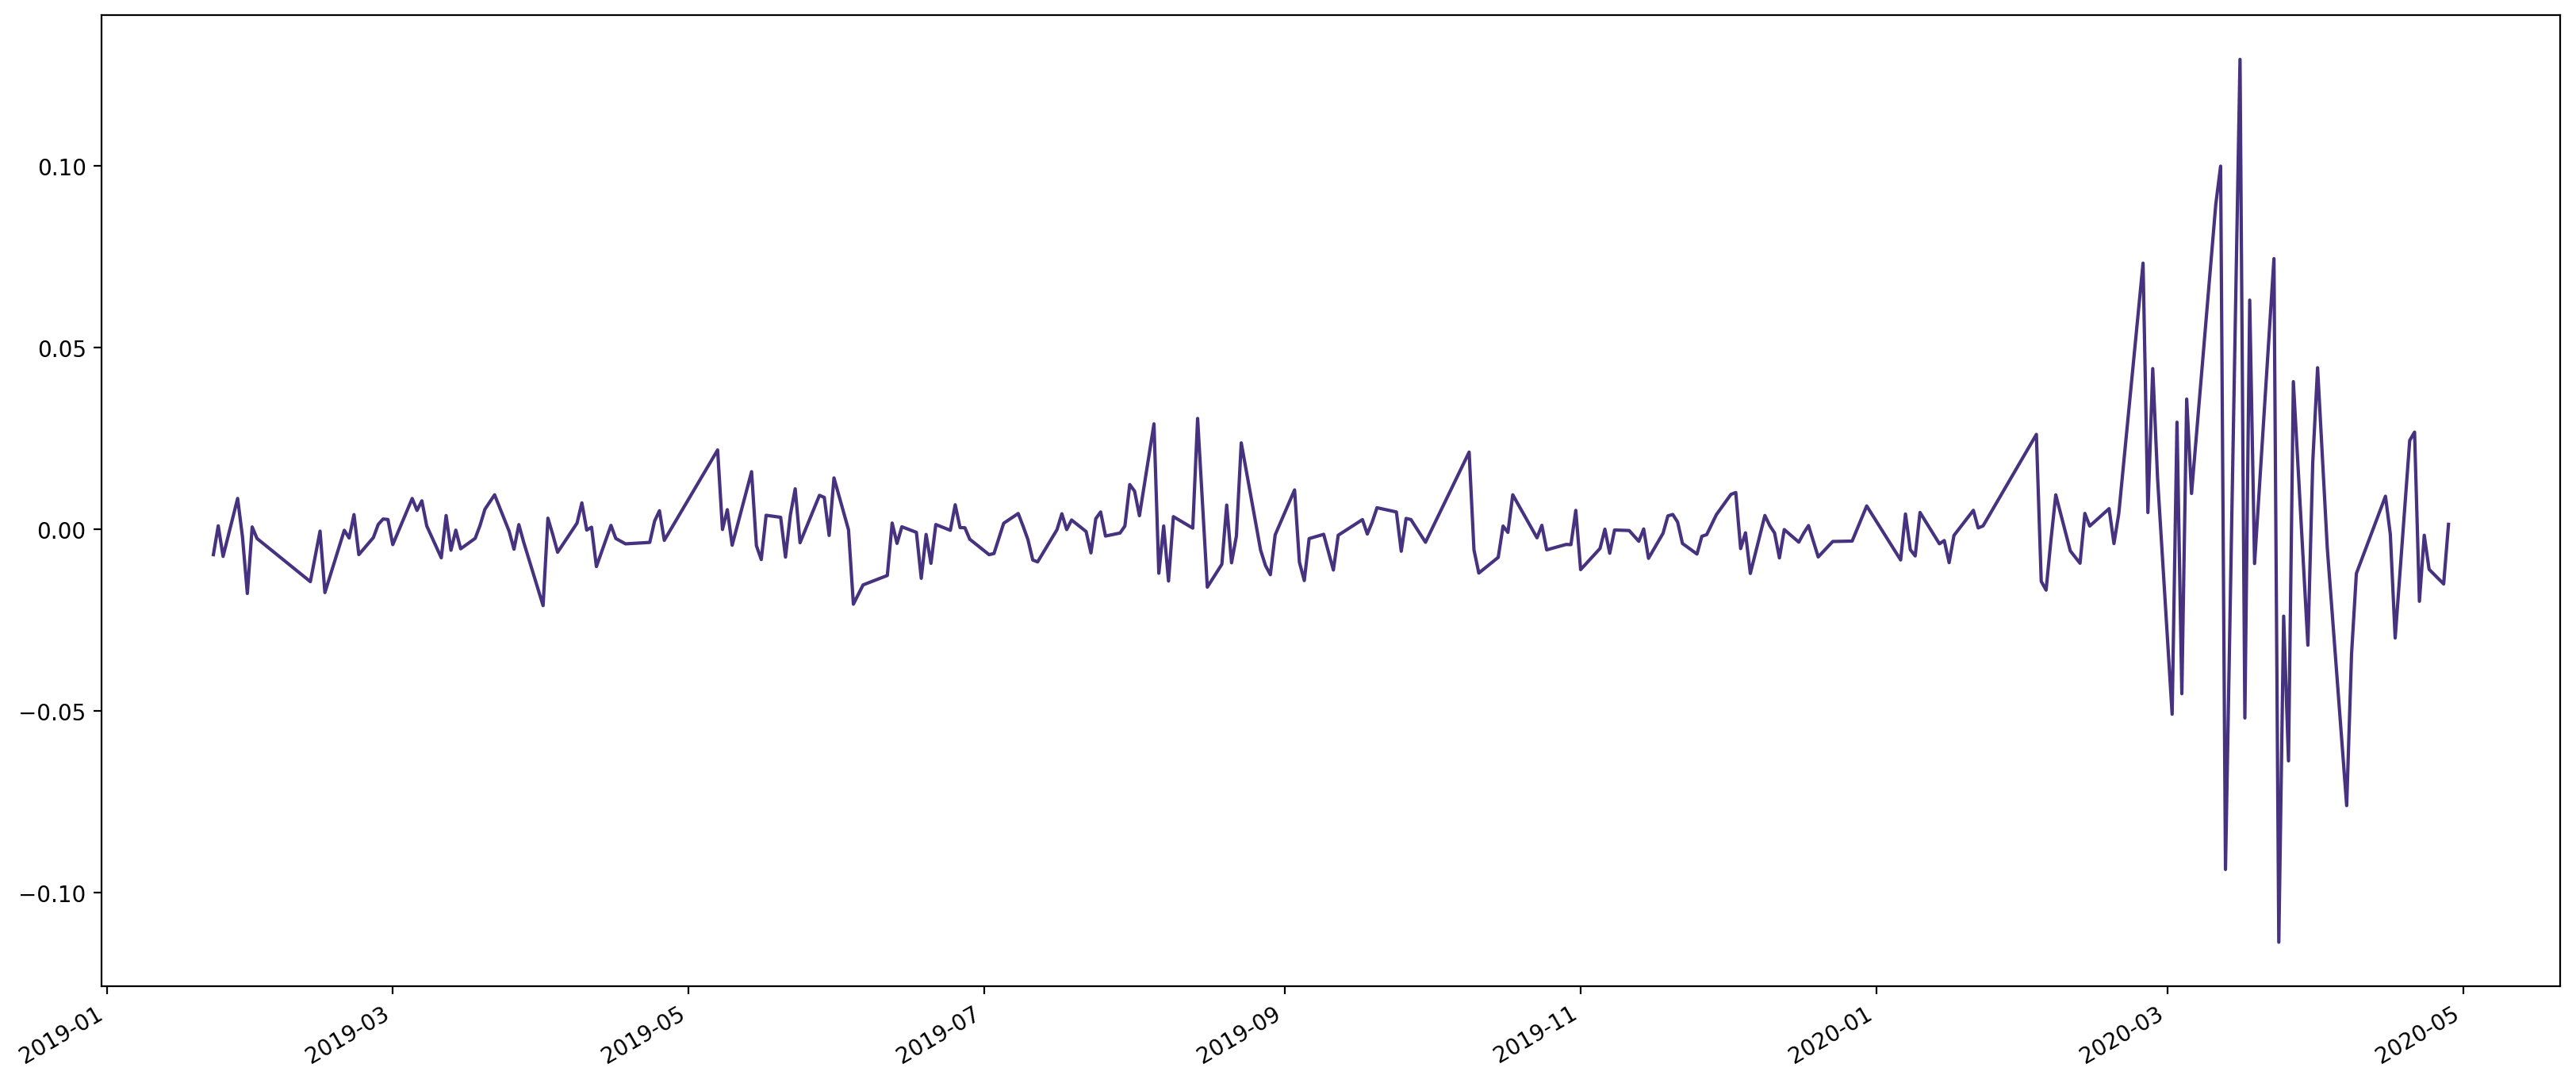

In [ ]:
stressed.plot()
plt.show()

The first thing to notice is that none of the three models were prepared for something so extreme as the volatility of the last few months. On the first day of 2020, our expected shortfall according the historical simulation is only `.025`! Not much later in February we see spikes of `.05` being quite common. Such losses were still expected by the GPD model, but then March exceeds all estimations.

We do have to note here that we are comparing VaR and ES of the first day of 2020 versus the first day of May. A next step could be to look at a rolling estimation, especially since we see GPD being able to adjust *very* well over that short period of time; ES going from `.048` to `.155`! It would be interesting to see what this looks like over time.

# Bibliography

- Cangelosi, R. and Goriely, A., 2007. Component retention in principal component analysis with application to cDNA microarray data. *Biology direct*, 2(1), p.2.
- Kourouma, L., Dupre, D., Sanfilippo, G. and Taramasco, O., 2010. Extreme value at risk and expected shortfall during financial crisis. *Available at SSRN 1744091*.
- Pearson, K., 1901. LIII. On lines and planes of closest fit to systems of points in space. *The London, Edinburgh, and Dublin Philosophical Magazine and Journal of Science*, 2(11), pp.559-572.